In [37]:
%load_ext autoreload
%autoreload 2

# Import packages

In [2]:
# standard data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

# parsing gtfs
# import pyranges as pr
# from swissisoform.src.swissisoform.genome import GenomeHandler

# convenience
from tqdm import tqdm

In [2]:
from filter_utils import *

In [3]:
# Adapted from swissisoform.genome without the GenomeHandler object
def load_transcript_annotations(gtf_path: str, nrows=None) -> pd.DataFrame:
    """Load and parse GTF annotations into a pandas DataFrame.

    Args:
        gtf_path (str): Path to the genome annotation GTF file.

    Returns:
        annotations (pd.DataFrame)
    """
    features_list = []
    if nrows is None:
        nrows = np.inf
    counter = 0

    with open(gtf_path) as handle:
        for line in handle:
            counter += 1

            # skip the header
            if line.startswith("#"):
                continue

            # stop parsing if nrows exceeded
            if counter > nrows:
                break

            # only look at transcript annotations
            if '\ttranscript\t' in line:
                fields = line.strip().split("\t")

                if len(fields) != 9:
                    continue

                # leave attributes as a sting to parse
                attribute_string = fields[8]

                feature_dict = {
                    "chromosome": fields[0],
                    "source": fields[1],
                    "feature_type": fields[2],
                    "start": int(fields[3]),
                    "end": int(fields[4]),
                    "score": fields[5],
                    "strand": fields[6],
                    "frame": fields[7],
                    "attributes": fields[8],
                }

                features_list.append(feature_dict)
    
    annotations = pd.DataFrame(features_list)

    base_columns = ['chromosome', 'source', 'feature_type', 'start', 'end', 'score', 'strand', 'frame']
    extracted_columns = ['gene_id', 'gene_type', 'transcript_id', 'transcript_type', 'transcript_support_level']
    tags = ['MANE_Select']

    for col in extracted_columns:
        annotations[col] = annotations['attributes'].str.extract(f'{col} "([^"]*)"')
    for tag in tags:
        annotations[tag] = annotations['attributes'].str.contains(tag)

    annotations_sorted = annotations[base_columns + extracted_columns + tags + ['attributes']]

    return annotations_sorted

# Import data

In [6]:
tis_df = pd.read_csv('/lab/barcheese01/aTIS_data/ribotish/HeLa_TIS_predict.txt', sep='\t')
tis_df.columns

Index(['Gid', 'Tid', 'Symbol', 'GeneType', 'GenomePos', 'StartCodon', 'Start',
       'Stop', 'TisType', 'TISGroup', 'TISCounts', 'TISPvalue', 'RiboPvalue',
       'RiboPStatus', 'FisherPvalue', 'TISQvalue', 'FrameQvalue',
       'FisherQvalue', 'AALen', 'Seq', 'AASeq'],
      dtype='str')

In [7]:
gtf_df = load_transcript_annotations(
    '/lab/barcheese01/aTIS_data/ribotish/gencode.v49.primary_assembly.annotation.gtf'
)
gtf_df.columns

Index(['chromosome', 'source', 'feature_type', 'start', 'end', 'score',
       'strand', 'frame', 'gene_id', 'gene_type', 'transcript_id',
       'transcript_type', 'transcript_support_level', 'MANE_Select',
       'attributes'],
      dtype='str')

In [ ]:
gtf_df[gtf_df['MANE_Select']]['transcript_support_level'].value_counts()

transcript_support_level
1     14206
5      1438
NA     1138
2      1039
3       149
4        35
Name: count, dtype: int64

# Filter data

In [8]:
# simplify df to relevant columns
tis_df_mini = tis_df.loc[
    :, ['Gid', 'Tid', 'Symbol', 'StartCodon', 'Start',
    'TisType', 'TISGroup', 'TISCounts', 'GenomePos', 'Seq', 'AASeq']
]
annotated_tis_df = tis_df_mini.merge(
    gtf_df, how='left', left_on=['Gid', 'Tid'], right_on=['gene_id', 'transcript_id']
)
annotated_tis_df.columns

Index(['Gid', 'Tid', 'Symbol', 'StartCodon', 'Start', 'TisType', 'TISGroup',
       'TISCounts', 'GenomePos', 'Seq', 'AASeq', 'chromosome', 'source',
       'feature_type', 'start', 'end', 'score', 'strand', 'frame', 'gene_id',
       'gene_type', 'transcript_id', 'transcript_type',
       'transcript_support_level', 'MANE_Select', 'attributes'],
      dtype='str')

In [78]:
annotated_tis_df.value_counts('MANE_Select')

MANE_Select
False    360053
True      33379
Name: count, dtype: int64

In [79]:
annotated_tis_df.value_counts(['MANE_Select', 'transcript_support_level']).sort_index(level=[0, 1])

MANE_Select  transcript_support_level
False        1                           26970
             2                           21448
             3                            7062
             4                            3746
             5                           18050
             NA                            483
True         1                           27577
             2                            1394
             3                              49
             4                               7
             5                            2180
             NA                            486
Name: count, dtype: int64

In [70]:
annotated_tis_df.value_counts(['MANE_Select', 'TisType'])

MANE_Select  TisType                 
False        Truncated                   199483
             Annotated                    72657
             Extended                     23244
True         Truncated                    21940
False        Novel:CDSFrameOverlap        20163
             5'UTR                        16131
True         Annotated                     6346
False        3'UTR:CDSFrameOverlap         6076
             Novel                         5640
             Novel:Known                   4943
             Truncated:Known               4354
             Extended:CDSFrameOverlap      3313
True         Extended                      2769
False        Internal                      1608
True         5'UTR                         1437
False        Internal:CDSFrameOverlap       794
             5'UTR:CDSFrameOverlap          496
             Extended:Known                 486
True         Truncated:Known                425
False        5'UTR:Known                    386
  

In [11]:
tis_groupings = annotated_tis_df.groupby(
    ['MANE_Select', 'transcript_support_level', 'TisType']
)
tis_group_counts = tis_groupings.count()['StartCodon']

(0.0, 0.005)

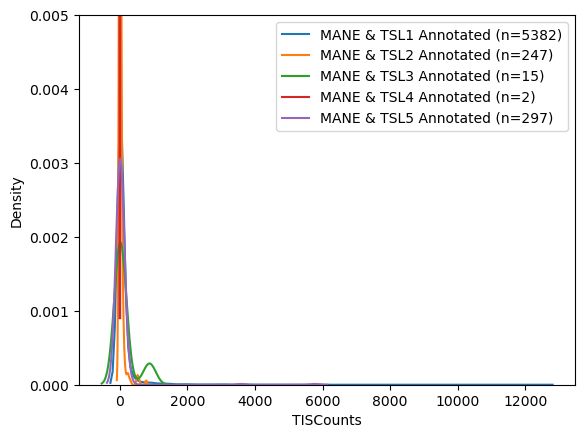

In [12]:
mane_selects = [True]
tsls = ['1', '2', '3', '4', '5']
tis_types = ['Annotated']

for ms in mane_selects:
    mane_string = '' if ms else 'not '
    for tsl in tsls:
        for tis_type in tis_types:
            sns.kdeplot(
                annotated_tis_df[
                    (annotated_tis_df['MANE_Select'] == ms) & 
                    (annotated_tis_df['transcript_support_level'] == tsl) & 
                    (annotated_tis_df['TisType'] == tis_type)
                ]['TISCounts'],
                label=f'{mane_string}MANE & TSL{tsl} {tis_type} (n={tis_group_counts.loc[ms, tsl, tis_type]})'
            )

plt.legend()
plt.ylim(0, 0.005)

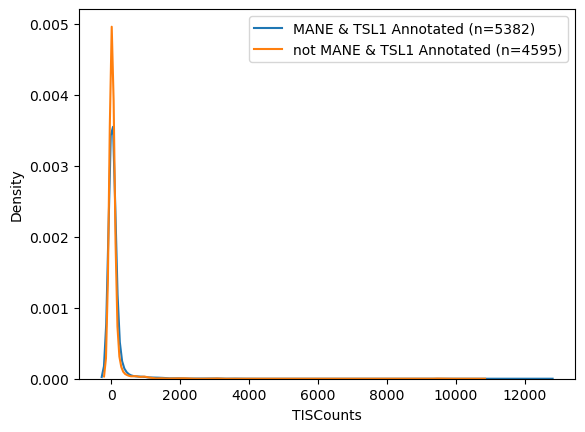

In [100]:
mane_selects = [True, False]
tsls = ['1']
tis_types = ['Annotated']

for ms in mane_selects:
    mane_string = '' if ms else 'not '
    for tsl in tsls:
        for tis_type in tis_types:
            sns.kdeplot(
                annotated_tis_df[
                    (annotated_tis_df['MANE_Select'] == ms) & 
                    (annotated_tis_df['transcript_support_level'] == tsl) & 
                    (annotated_tis_df['TisType'] == tis_type)
                ]['TISCounts'],
                label=f'{mane_string}MANE & TSL{tsl} {tis_type} (n={tis_group_counts.loc[ms, tsl, tis_type]})'
            )

plt.legend()

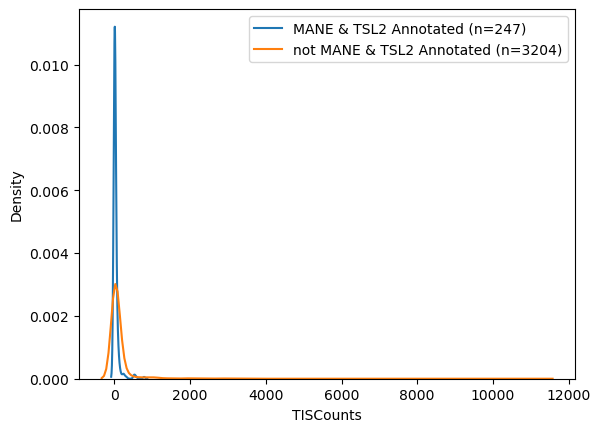

In [ ]:
mane_selects = [True, False]
tsls = ['2']
tis_types = ['Annotated']

for ms in mane_selects:
    mane_string = '' if ms else 'not '
    for tsl in tsls:
        for tis_type in tis_types:
            sns.kdeplot(
                annotated_tis_df[
                    (annotated_tis_df['MANE_Select'] == ms) & 
                    (annotated_tis_df['transcript_support_level'] == tsl) & 
                    (annotated_tis_df['TisType'] == tis_type)
                ]['TISCounts'],
                label=f'{mane_string}MANE & TSL{tsl} {tis_type} (n={tis_group_counts.loc[ms, tsl, tis_type]})'
            )

plt.legend()

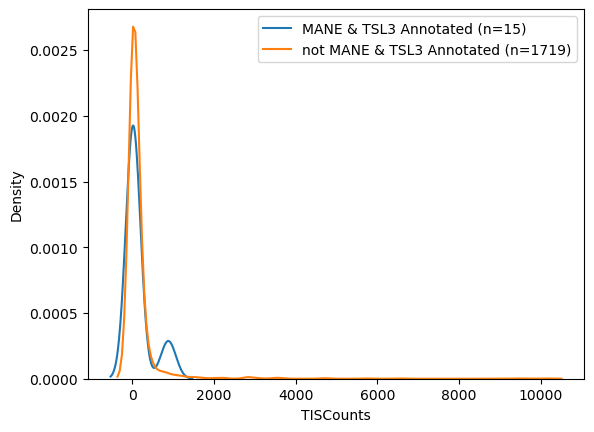

In [102]:
mane_selects = [True, False]
tsls = ['3']
tis_types = ['Annotated']

for ms in mane_selects:
    mane_string = '' if ms else 'not '
    for tsl in tsls:
        for tis_type in tis_types:
            sns.kdeplot(
                annotated_tis_df[
                    (annotated_tis_df['MANE_Select'] == ms) & 
                    (annotated_tis_df['transcript_support_level'] == tsl) & 
                    (annotated_tis_df['TisType'] == tis_type)
                ]['TISCounts'],
                label=f'{mane_string}MANE & TSL{tsl} {tis_type} (n={tis_group_counts.loc[ms, tsl, tis_type]})'
            )

plt.legend()

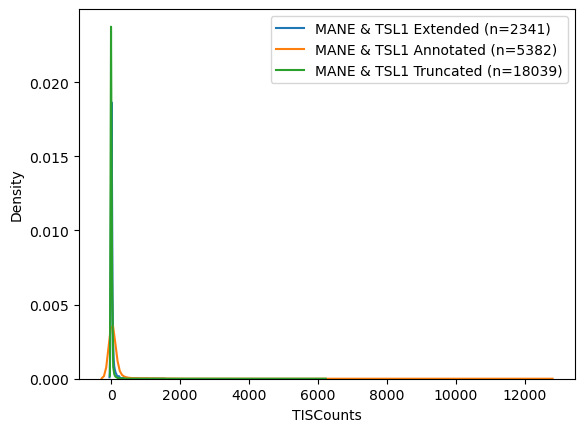

In [103]:
mane_selects = [True]
tsls = ['1']
tis_types = ['Extended', 'Annotated', 'Truncated']

for ms in mane_selects:
    mane_string = '' if ms else 'not '
    for tsl in tsls:
        for tis_type in tis_types:
            sns.kdeplot(
                annotated_tis_df[
                    (annotated_tis_df['MANE_Select'] == ms) & 
                    (annotated_tis_df['transcript_support_level'] == tsl) & 
                    (annotated_tis_df['TisType'].str.contains(tis_type))
                ]['TISCounts'],
                label=f'{mane_string}MANE & TSL{tsl} {tis_type} (n={tis_group_counts.loc[ms, tsl, tis_type]})'
            )

plt.legend()

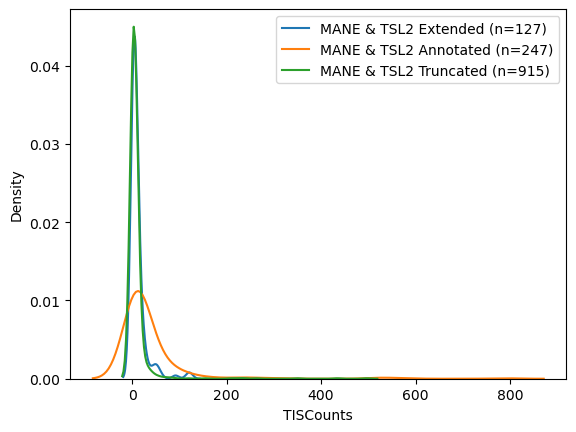

In [104]:
mane_selects = [True]
tsls = ['2']
tis_types = ['Extended', 'Annotated', 'Truncated']

for ms in mane_selects:
    mane_string = '' if ms else 'not '
    for tsl in tsls:
        for tis_type in tis_types:
            sns.kdeplot(
                annotated_tis_df[
                    (annotated_tis_df['MANE_Select'] == ms) & 
                    (annotated_tis_df['transcript_support_level'] == tsl) & 
                    (annotated_tis_df['TisType'].str.contains(tis_type))
                ]['TISCounts'],
                label=f'{mane_string}MANE & TSL{tsl} {tis_type} (n={tis_group_counts.loc[ms, tsl, tis_type]})'
            )

plt.legend()

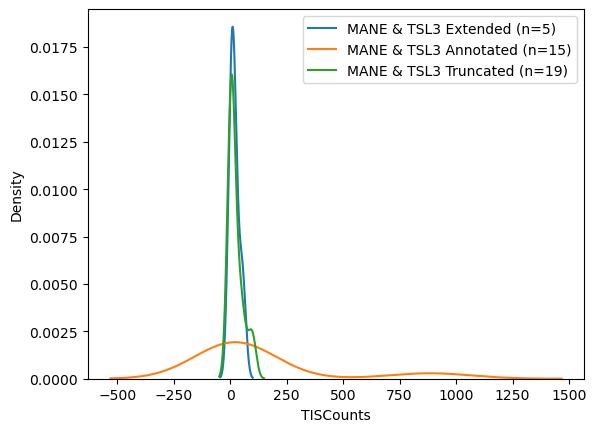

In [105]:
mane_selects = [True]
tsls = ['3']
tis_types = ['Extended', 'Annotated', 'Truncated']

for ms in mane_selects:
    mane_string = '' if ms else 'not '
    for tsl in tsls:
        for tis_type in tis_types:
            sns.kdeplot(
                annotated_tis_df[
                    (annotated_tis_df['MANE_Select'] == ms) & 
                    (annotated_tis_df['transcript_support_level'] == tsl) & 
                    (annotated_tis_df['TisType'].str.contains(tis_type))
                ]['TISCounts'],
                label=f'{mane_string}MANE & TSL{tsl} {tis_type} (n={tis_group_counts.loc[ms, tsl, tis_type]})'
            )

plt.legend()

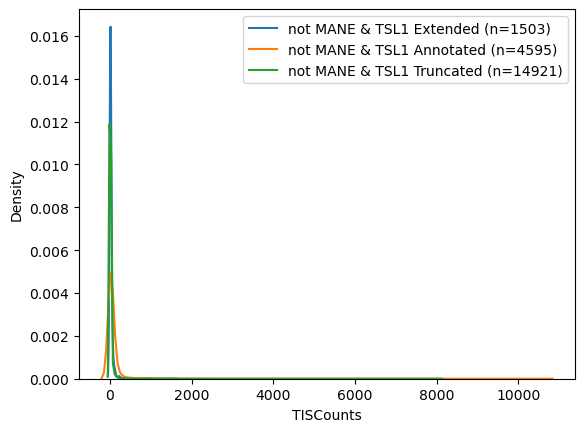

In [107]:
mane_selects = [False]
tsls = ['1']
tis_types = ['Extended', 'Annotated', 'Truncated']

for ms in mane_selects:
    mane_string = '' if ms else 'not '
    for tsl in tsls:
        for tis_type in tis_types:
            sns.kdeplot(
                annotated_tis_df[
                    (annotated_tis_df['MANE_Select'] == ms) & 
                    (annotated_tis_df['transcript_support_level'] == tsl) & 
                    (annotated_tis_df['TisType'].str.contains(tis_type))
                ]['TISCounts'],
                label=f'{mane_string}MANE & TSL{tsl} {tis_type} (n={tis_group_counts.loc[ms, tsl, tis_type]})'
            )

plt.legend()

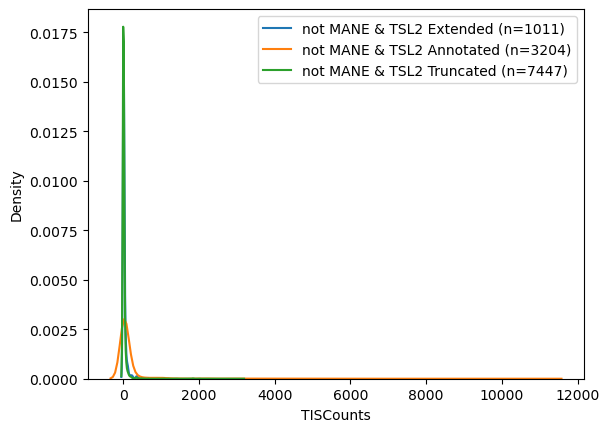

In [108]:
mane_selects = [False]
tsls = ['2']
tis_types = ['Extended', 'Annotated', 'Truncated']

for ms in mane_selects:
    mane_string = '' if ms else 'not '
    for tsl in tsls:
        for tis_type in tis_types:
            sns.kdeplot(
                annotated_tis_df[
                    (annotated_tis_df['MANE_Select'] == ms) & 
                    (annotated_tis_df['transcript_support_level'] == tsl) & 
                    (annotated_tis_df['TisType'].str.contains(tis_type))
                ]['TISCounts'],
                label=f'{mane_string}MANE & TSL{tsl} {tis_type} (n={tis_group_counts.loc[ms, tsl, tis_type]})'
            )

plt.legend()

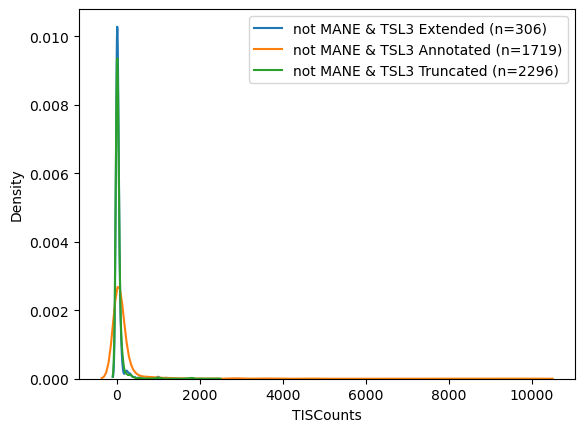

In [109]:
mane_selects = [False]
tsls = ['3']
tis_types = ['Extended', 'Annotated', 'Truncated']

for ms in mane_selects:
    mane_string = '' if ms else 'not '
    for tsl in tsls:
        for tis_type in tis_types:
            sns.kdeplot(
                annotated_tis_df[
                    (annotated_tis_df['MANE_Select'] == ms) & 
                    (annotated_tis_df['transcript_support_level'] == tsl) & 
                    (annotated_tis_df['TisType'].str.contains(tis_type))
                ]['TISCounts'],
                label=f'{mane_string}MANE & TSL{tsl} {tis_type} (n={tis_group_counts.loc[ms, tsl, tis_type]})'
            )

plt.legend()

# Overview of steps:
1. Define a set of reference transcripts
    - Write a function for this operation
    - Can use a combination of criteria such as:
        - "MANE_Select" == True
        - "TISCounts" > T or percentile
        - "transcript_support_level".isin([1,2,3])
2. Given the reference transcripts, trim all alternative TISs within a neighborhood of the reference per gene (dist > T)
    - Write a function for this operation
    - First groupby transcript_id, keep the reference set, then iteratively:
        - exclude the neighbors of the reference set
        - select other elements (by counts, TSL) to add to the reference set
        - stop when no more added elements meet the seleciton criteria

For each set of filters, break down the number of TISs kept and discarded that fall into the count percentile ranges

In [13]:
percentiles = [50, 75, 90, 95]
percentile_values = {0: 0}
for p in percentiles:
    percentile_values[p] = np.percentile(annotated_tis_df['TISCounts'], p)
percentile_values[100] = annotated_tis_df['TISCounts'].max()

In [17]:
annotated_tis_df['tis_count_bins'] = pd.cut(
    annotated_tis_df['TISCounts'], bins=percentile_values.values()
)
annotated_tis_df['tis_count_bins'].cat.categories.tolist()

[Interval(0.0, 7.0, closed='right'),
 Interval(7.0, 21.0, closed='right'),
 Interval(21.0, 63.0, closed='right'),
 Interval(63.0, 124.0, closed='right'),
 Interval(124.0, 18962.0, closed='right')]

[Text(0.5, 0, '> 0th\n(0.0, 7.0]'),
 Text(1.5, 0, '> 50th\n(7.0, 21.0]'),
 Text(2.5, 0, '> 75th\n(21.0, 63.0]'),
 Text(3.5, 0, '> 90th\n(63.0, 124.0]'),
 Text(4.5, 0, '> 95th\n(124.0, 18962.0]')]

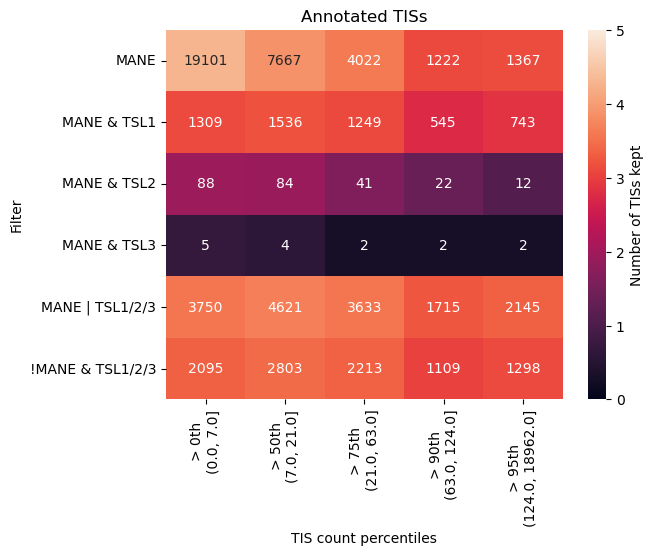

In [34]:
ms = [True]
tistypes = ['Annotated']
filter_keep_heatmap = pd.concat([
    annotated_tis_df[
        annotated_tis_df['MANE_Select'].isin(ms)
    ].value_counts('tis_count_bins').rename('MANE'),
    annotated_tis_df[
        annotated_tis_df['MANE_Select'].isin(ms) &
        (annotated_tis_df['transcript_support_level'] == '1') & 
        (annotated_tis_df['TisType'].str.contains('|'.join(tistypes)))
    ].value_counts('tis_count_bins').rename('MANE & TSL1'),
    annotated_tis_df[
        annotated_tis_df['MANE_Select'].isin(ms) &
        (annotated_tis_df['transcript_support_level'] == '2') & 
        (annotated_tis_df['TisType'].str.contains('|'.join(tistypes)))
    ].value_counts('tis_count_bins').rename('MANE & TSL2'),
    annotated_tis_df[
        annotated_tis_df['MANE_Select'].isin(ms) &
        (annotated_tis_df['transcript_support_level'] == '3') & 
        (annotated_tis_df['TisType'].str.contains('|'.join(tistypes)))
    ].value_counts('tis_count_bins').rename('MANE & TSL3'),
    annotated_tis_df[
        (annotated_tis_df['MANE_Select'].isin(ms) |
        (annotated_tis_df['transcript_support_level'].isin(['1', '2', '3']))) & 
        (annotated_tis_df['TisType'].str.contains('|'.join(tistypes)))
    ].value_counts('tis_count_bins').rename('MANE | TSL1/2/3'),
    annotated_tis_df[
        (~annotated_tis_df['MANE_Select'].isin(ms) &
        (annotated_tis_df['transcript_support_level'].isin(['1', '2', '3']))) & 
        (annotated_tis_df['TisType'].str.contains('|'.join(tistypes)))
    ].value_counts('tis_count_bins').rename('!MANE & TSL1/2/3')
], axis=1).T.loc[
    :, annotated_tis_df['tis_count_bins'].cat.categories.tolist()
]

sns.heatmap(
    np.log10(filter_keep_heatmap), 
    annot=filter_keep_heatmap,
    fmt='.0f',
    cbar_kws={'label': 'Number of TISs kept'},
    vmin=0, vmax=5
)

plt.title(f'{",".join(tistypes)} TISs')
plt.ylabel('Filter')
plt.xlabel('TIS count percentiles')
xticklabels = plt.gca().get_xticklabels()
for pct, xtl in zip(['> 0th', '> 50th', '> 75th', '> 90th', '> 95th'], xticklabels):
    xtl.set_text('\n'.join([pct, xtl.get_text()]))
plt.gca().set_xticklabels(xticklabels)

/lab/barcheese01/smaffa/miniforge3/envs/riboseq/lib/python3.11/site-packages/pandas/core/internals/blocks.py:347: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


[Text(0.5, 0, '> 0th\n(0.0, 7.0]'),
 Text(1.5, 0, '> 50th\n(7.0, 21.0]'),
 Text(2.5, 0, '> 75th\n(21.0, 63.0]'),
 Text(3.5, 0, '> 90th\n(63.0, 124.0]'),
 Text(4.5, 0, '> 95th\n(124.0, 18962.0]')]

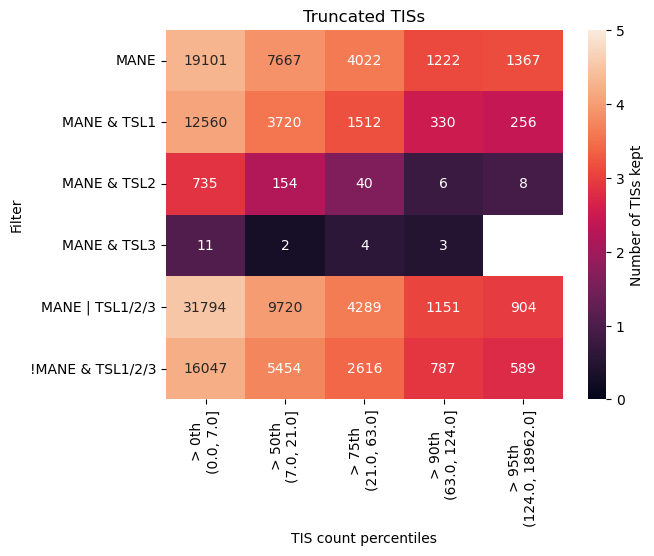

In [35]:
ms = [True]
tistypes = ['Truncated']
filter_keep_heatmap = pd.concat([
    annotated_tis_df[
        annotated_tis_df['MANE_Select'].isin(ms)
    ].value_counts('tis_count_bins').rename('MANE'),
    annotated_tis_df[
        annotated_tis_df['MANE_Select'].isin(ms) &
        (annotated_tis_df['transcript_support_level'] == '1') & 
        (annotated_tis_df['TisType'].str.contains('|'.join(tistypes)))
    ].value_counts('tis_count_bins').rename('MANE & TSL1'),
    annotated_tis_df[
        annotated_tis_df['MANE_Select'].isin(ms) &
        (annotated_tis_df['transcript_support_level'] == '2') & 
        (annotated_tis_df['TisType'].str.contains('|'.join(tistypes)))
    ].value_counts('tis_count_bins').rename('MANE & TSL2'),
    annotated_tis_df[
        annotated_tis_df['MANE_Select'].isin(ms) &
        (annotated_tis_df['transcript_support_level'] == '3') & 
        (annotated_tis_df['TisType'].str.contains('|'.join(tistypes)))
    ].value_counts('tis_count_bins').rename('MANE & TSL3'),
    annotated_tis_df[
        (annotated_tis_df['MANE_Select'].isin(ms) |
        (annotated_tis_df['transcript_support_level'].isin(['1', '2', '3']))) & 
        (annotated_tis_df['TisType'].str.contains('|'.join(tistypes)))
    ].value_counts('tis_count_bins').rename('MANE | TSL1/2/3'),
    annotated_tis_df[
        (~annotated_tis_df['MANE_Select'].isin(ms) &
        (annotated_tis_df['transcript_support_level'].isin(['1', '2', '3']))) & 
        (annotated_tis_df['TisType'].str.contains('|'.join(tistypes)))
    ].value_counts('tis_count_bins').rename('!MANE & TSL1/2/3')
], axis=1).T.loc[
    :, annotated_tis_df['tis_count_bins'].cat.categories.tolist()
]

sns.heatmap(
    np.log10(filter_keep_heatmap), 
    annot=filter_keep_heatmap,
    fmt='.0f',
    cbar_kws={'label': 'Number of TISs kept'},
    vmin=0, vmax=5
)

plt.title(f'{",".join(tistypes)} TISs')
plt.ylabel('Filter')
plt.xlabel('TIS count percentiles')
xticklabels = plt.gca().get_xticklabels()
for pct, xtl in zip(['> 0th', '> 50th', '> 75th', '> 90th', '> 95th'], xticklabels):
    xtl.set_text('\n'.join([pct, xtl.get_text()]))
plt.gca().set_xticklabels(xticklabels)

/lab/barcheese01/smaffa/miniforge3/envs/riboseq/lib/python3.11/site-packages/pandas/core/internals/blocks.py:347: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


[Text(0.5, 0, '> 0th\n(0.0, 7.0]'),
 Text(1.5, 0, '> 50th\n(7.0, 21.0]'),
 Text(2.5, 0, '> 75th\n(21.0, 63.0]'),
 Text(3.5, 0, '> 90th\n(63.0, 124.0]'),
 Text(4.5, 0, '> 95th\n(124.0, 18962.0]')]

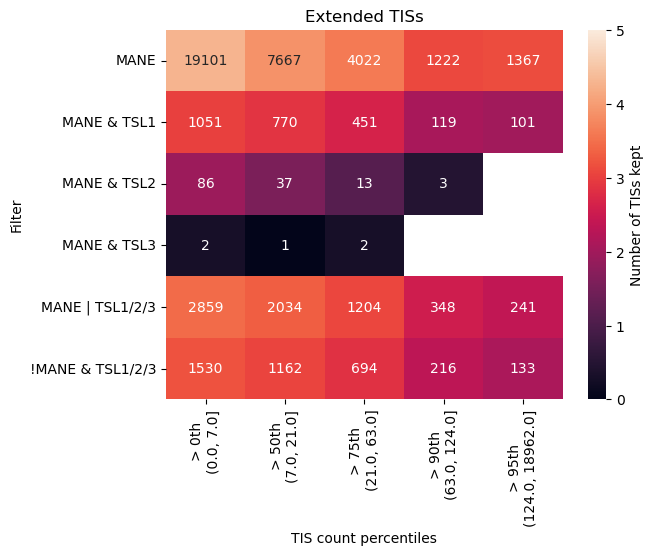

In [36]:
ms = [True]
tistypes = ['Extended']
filter_keep_heatmap = pd.concat([
    annotated_tis_df[
        annotated_tis_df['MANE_Select'].isin(ms)
    ].value_counts('tis_count_bins').rename('MANE'),
    annotated_tis_df[
        annotated_tis_df['MANE_Select'].isin(ms) &
        (annotated_tis_df['transcript_support_level'] == '1') & 
        (annotated_tis_df['TisType'].str.contains('|'.join(tistypes)))
    ].value_counts('tis_count_bins').rename('MANE & TSL1'),
    annotated_tis_df[
        annotated_tis_df['MANE_Select'].isin(ms) &
        (annotated_tis_df['transcript_support_level'] == '2') & 
        (annotated_tis_df['TisType'].str.contains('|'.join(tistypes)))
    ].value_counts('tis_count_bins').rename('MANE & TSL2'),
    annotated_tis_df[
        annotated_tis_df['MANE_Select'].isin(ms) &
        (annotated_tis_df['transcript_support_level'] == '3') & 
        (annotated_tis_df['TisType'].str.contains('|'.join(tistypes)))
    ].value_counts('tis_count_bins').rename('MANE & TSL3'),
    annotated_tis_df[
        (annotated_tis_df['MANE_Select'].isin(ms) |
        (annotated_tis_df['transcript_support_level'].isin(['1', '2', '3']))) & 
        (annotated_tis_df['TisType'].str.contains('|'.join(tistypes)))
    ].value_counts('tis_count_bins').rename('MANE | TSL1/2/3'),
    annotated_tis_df[
        (~annotated_tis_df['MANE_Select'].isin(ms) &
        (annotated_tis_df['transcript_support_level'].isin(['1', '2', '3']))) & 
        (annotated_tis_df['TisType'].str.contains('|'.join(tistypes)))
    ].value_counts('tis_count_bins').rename('!MANE & TSL1/2/3')
], axis=1).T.loc[
    :, annotated_tis_df['tis_count_bins'].cat.categories.tolist()
]

sns.heatmap(
    np.log10(filter_keep_heatmap), 
    annot=filter_keep_heatmap,
    fmt='.0f',
    cbar_kws={'label': 'Number of TISs kept'},
    vmin=0, vmax=5
)

plt.title(f'{",".join(tistypes)} TISs')
plt.ylabel('Filter')
plt.xlabel('TIS count percentiles')
xticklabels = plt.gca().get_xticklabels()
for pct, xtl in zip(['> 0th', '> 50th', '> 75th', '> 90th', '> 95th'], xticklabels):
    xtl.set_text('\n'.join([pct, xtl.get_text()]))
plt.gca().set_xticklabels(xticklabels)

In [ ]:
'''
Try: (filter down to MANE) | 
(TSL1/2/3 & counts > 90th percentile) & 
(TisType == 'Annotated') -> these become potenetial canonical TISs?
'''

# Prototype

In [9]:
tis_df = pd.read_csv('/lab/barcheese01/aTIS_data/ribotish/HeLa_TIS_predict.txt', sep='\t')
tis_df.columns

Index(['Gid', 'Tid', 'Symbol', 'GeneType', 'GenomePos', 'StartCodon', 'Start',
       'Stop', 'TisType', 'TISGroup', 'TISCounts', 'TISPvalue', 'RiboPvalue',
       'RiboPStatus', 'FisherPvalue', 'TISQvalue', 'FrameQvalue',
       'FisherQvalue', 'AALen', 'Seq', 'AASeq'],
      dtype='str')

In [ ]:
gtf_df = load_transcript_annotations(
    '/lab/barcheese01/aTIS_data/ribotish/gencode.v49.primary_assembly.annotation.gtf'
)
gtf_df.columns

In [10]:
# simplify df to relevant columns
tis_df_mini = tis_df.loc[
    :, ['Gid', 'Tid', 'Symbol', 'StartCodon', 'Start',
    'TisType', 'TISGroup', 'TISCounts', 'GenomePos', 'Seq', 'AASeq']
]
annotated_tis_df = tis_df_mini.merge(
    gtf_df, how='left', left_on=['Gid', 'Tid'], right_on=['gene_id', 'transcript_id']
)
annotated_tis_df.columns

Index(['Gid', 'Tid', 'Symbol', 'StartCodon', 'Start', 'TisType', 'TISGroup',
       'TISCounts', 'GenomePos', 'Seq', 'AASeq', 'chromosome', 'source',
       'feature_type', 'start', 'end', 'score', 'strand', 'frame', 'gene_id',
       'gene_type', 'transcript_id', 'transcript_type',
       'transcript_support_level', 'MANE_Select', 'attributes'],
      dtype='str')

In [2]:
def identify_reference_transcripts(
    tis_df, 
    transcript_support_levels=['1','2','3'], 
    min_tis_counts=None,
    min_percentile_tis_counts=90
):
    if min_percentile_tis_counts is not None:
        min_tis_counts = np.percentile(tis_df['TISCounts'], min_percentile_tis_counts)
    if min_tis_counts is None:
        min_tis_counts = 1

    tis_to_keep = []
    print(f'Selecting from {tis_df.shape[0]} TISs to use...')
    mane_mask = tis_df['MANE_Select'] == True
    print(f'Keeping {mane_mask.sum()} TISs for MANE_Select transcripts')
    tis_to_keep.append(tis_df[mane_mask])
    remaining_tis = tis_df[~mane_mask]

    supported_mask = (remaining_tis['TISCounts'] >= min_tis_counts)
    print(f'{supported_mask.sum()} remaining TISs have readcount support >= {min_tis_counts}...')
    tsl_mask = (remaining_tis['transcript_support_level'].isin(transcript_support_levels))
    print(f'{tsl_mask.sum()} remaining TISs are transcript support level {"/".join(transcript_support_levels)}...')
    support_and_tsl_mask = supported_mask & tsl_mask
    print(f'Keeping {support_and_tsl_mask.sum()} TISs with both annotated and empirical support')
    tis_to_keep.append(remaining_tis[support_and_tsl_mask])
    
    tis_to_keep = pd.concat(tis_to_keep, axis=0)
    annotated_mask = tis_to_keep['TisType'].str.contains('Annotated')
    tids_to_keep = tis_to_keep[annotated_mask]['Tid'].unique().tolist()
    print(f'{annotated_mask.sum()} of these TISs have annotated start sites, representing {len(tids_to_keep)} unique transcript IDs')
    
    return tids_to_keep

In [27]:
reference_tids = identify_reference_transcripts(
    annotated_tis_df, 
    transcript_support_levels=['1','2','3'],
    min_percentile_tis_counts=90
)

Selecting from 393432 TISs to use...
Keeping 33379 TISs for MANE_Select transcripts
36795 remaining TISs have readcount support >= 63.0...
55480 remaining TISs are transcript support level 1/2/3...
Keeping 6309 TISs with both annotated and empirical support
8778 of these TISs have annotated start sites, representing 8778 unique transcript IDs


In [3]:
def filter_ribotish_results(
    tis_df, 
    transcript_support_levels=['1','2','3'], 
    min_tis_counts=None,
    min_percentile_tis_counts=90,
    tis_distance_buffer=30
):
    reference_tids = identify_reference_transcripts(
        tis_df, 
        transcript_support_levels=transcript_support_levels,
        min_tis_counts=min_tis_counts,
        min_percentile_tis_counts=min_percentile_tis_counts
    )

    print(f'Identified {len(reference_tids)} transcript IDs to use...')
    reference_mask = tis_df['Tid'].isin(reference_tids)
    print(f'{reference_mask.sum()} TISs are mapped to these transcript IDs...')
    reference_tis_df = tis_df[reference_mask]

    tis_to_keep = []
    for tid, idxs in tqdm(reference_tis_df.groupby('Tid').groups.items()):
        subset = reference_tis_df.loc[idxs, :].sort_values(['TISCounts'], ascending=False)
        while subset.shape[0] > 0:
            # take top TIS (prioitizing annotated MANE), then remove it and its neighbors
            mane_annotated_mask = (subset['MANE_Select'] == True) & subset['TisType'].str.contains('Annotated')
            if mane_annotated_mask.sum() > 0:
                selected_tis = subset[mane_annotated_mask].head(n=1)
            else:
                selected_tis = subset.head(n=1)

            # identify TISs downstream of it
            selected_tis_start = selected_tis.loc[:, 'Start'].iloc[0]
            downstream_mask = (subset['Start'] >= selected_tis_start) & (subset['Start'] <= (selected_tis_start + tis_distance_buffer))

            # keep the top TIS and remove the rest
            tis_to_keep.append(selected_tis)
            subset = subset[~downstream_mask]

    filtered_tis_df = pd.concat(tis_to_keep, axis=0)
    print(f'Keeping {filtered_tis_df.shape[0]} TISs from reference transcripts, excluding TISs within {tis_distance_buffer} nt of each other')
    return filtered_tis_df.reset_index(drop=True)

In [47]:
filtered_tis_df = filter_ribotish_results(
    annotated_tis_df, 
    transcript_support_levels=['1','2','3'], 
    min_tis_counts=None,
    min_percentile_tis_counts=90,
    tis_distance_buffer=30
)

Selecting from 393432 TISs to use...
Keeping 33379 TISs for MANE_Select transcripts
36795 remaining TISs have readcount support >= 63.0...
55480 remaining TISs are transcript support level 1/2/3...
Keeping 6309 TISs with both annotated and empirical support
8778 of these TISs have annotated start sites, representing 8778 unique transcript IDs
Identified 8778 transcript IDs to use...
32266 TISs are mapped to these transcript IDs...


100%|██████████| 8778/8778 [01:07<00:00, 130.85it/s]


Keeping 24963 TISs from reference transcripts, excluding TISs within 30 nt of each other


In [4]:
trim_columns = [
    'Gid', 'Tid', 'Symbol', 
    'StartCodon', 'Start', 'TisType', 'TISGroup', 'TISCounts', 
    'GenomePos', 'Seq', 'AASeq', 'feature_type', 'strand', 'frame',
    'gene_type', 'transcript_type', 'transcript_support_level', 'MANE_Select'
]

# Run for all datasets

In [3]:
# standard data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

# convenience
from tqdm import tqdm

In [4]:
# Adapted from swissisoform.genome without the GenomeHandler object
def load_transcript_annotations(gtf_path: str, nrows=None) -> pd.DataFrame:
    """Load and parse GTF annotations into a pandas DataFrame.

    Args:
        gtf_path (str): Path to the genome annotation GTF file.

    Returns:
        annotations (pd.DataFrame)
    """
    features_list = []
    if nrows is None:
        nrows = np.inf
    counter = 0

    with open(gtf_path) as handle:
        for line in handle:
            counter += 1

            # skip the header
            if line.startswith("#"):
                continue

            # stop parsing if nrows exceeded
            if counter > nrows:
                break

            # only look at transcript annotations
            if '\ttranscript\t' in line:
                fields = line.strip().split("\t")

                if len(fields) != 9:
                    continue

                # leave attributes as a sting to parse
                attribute_string = fields[8]

                feature_dict = {
                    "chromosome": fields[0],
                    "source": fields[1],
                    "feature_type": fields[2],
                    "start": int(fields[3]),
                    "end": int(fields[4]),
                    "score": fields[5],
                    "strand": fields[6],
                    "frame": fields[7],
                    "attributes": fields[8],
                }

                features_list.append(feature_dict)
    
    annotations = pd.DataFrame(features_list)

    base_columns = ['chromosome', 'source', 'feature_type', 'start', 'end', 'score', 'strand', 'frame']
    extracted_columns = ['gene_id', 'gene_type', 'transcript_id', 'transcript_type', 'transcript_support_level']
    tags = ['MANE_Select']

    for col in extracted_columns:
        annotations[col] = annotations['attributes'].str.extract(f'{col} "([^"]*)"')
    for tag in tags:
        annotations[tag] = annotations['attributes'].str.contains(tag)

    annotations_sorted = annotations[base_columns + extracted_columns + tags + ['attributes']]

    return annotations_sorted

def import_ribotish_results(filepath, gtf_df=None):
    tis_df = pd.read_csv(filepath, sep='\t')
    if gtf_df is not None:
        # simplify df to relevant columns
        tis_df_mini = tis_df.loc[
            :, ['Gid', 'Tid', 'Symbol', 'StartCodon', 'Start',
            'TisType', 'TISGroup', 'TISCounts', 'TISQvalue', 'GenomePos', 'Seq', 'AASeq']
        ]
        annotated_tis_df = tis_df_mini.merge(
            gtf_df, how='left', left_on=['Gid', 'Tid'], right_on=['gene_id', 'transcript_id']
        )
        return annotated_tis_df
    else:
        return tis_df
    
def identify_reference_transcripts(
    tis_df, 
    transcript_support_levels=['1','2','3'], 
    min_tis_counts=None,
    min_percentile_tis_counts=90
):
    if min_percentile_tis_counts is not None:
        min_tis_counts = np.percentile(tis_df['TISCounts'], min_percentile_tis_counts)
    if min_tis_counts is None:
        min_tis_counts = 1

    tis_to_keep = []
    print(f'Selecting from {tis_df.shape[0]} TISs to use...')
    mane_mask = tis_df['MANE_Select'] == True
    print(f'Keeping {mane_mask.sum()} TISs for MANE_Select transcripts')
    tis_to_keep.append(tis_df[mane_mask])
    remaining_tis = tis_df[~mane_mask]

    supported_mask = (remaining_tis['TISCounts'] >= min_tis_counts)
    print(f'{supported_mask.sum()} remaining TISs have readcount support >= {min_tis_counts}...')
    tsl_mask = (remaining_tis['transcript_support_level'].isin(transcript_support_levels))
    print(f'{tsl_mask.sum()} remaining TISs are transcript support level {"/".join(transcript_support_levels)}...')
    support_and_tsl_mask = supported_mask & tsl_mask
    print(f'Keeping {support_and_tsl_mask.sum()} TISs with both annotated and empirical support')
    tis_to_keep.append(remaining_tis[support_and_tsl_mask])
    
    tis_to_keep = pd.concat(tis_to_keep, axis=0)
    annotated_mask = tis_to_keep['TisType'].str.contains('Annotated')
    tids_to_keep = tis_to_keep[annotated_mask]['Tid'].unique().tolist()
    print(f'{annotated_mask.sum()} of these TISs have annotated start sites, representing {len(tids_to_keep)} unique transcript IDs')
    
    return tids_to_keep

def filter_ribotish_results(
    tis_df, 
    transcript_support_levels=['1','2','3'], 
    min_tis_counts=None,
    min_percentile_tis_counts=90,
    tis_distance_buffer=30,
    min_putative_tis_counts=6
):
    reference_tids = identify_reference_transcripts(
        tis_df, 
        transcript_support_levels=transcript_support_levels,
        min_tis_counts=min_tis_counts,
        min_percentile_tis_counts=min_percentile_tis_counts
    )

    print(f'Identified {len(reference_tids)} transcript IDs to use...')
    reference_mask = tis_df['Tid'].isin(reference_tids)
    print(f'{reference_mask.sum()} TISs are mapped to these transcript IDs...')
    reference_tis_df = tis_df[reference_mask]

    tis_to_keep = []
    for tid, idxs in tqdm(reference_tis_df.groupby('Tid').groups.items()):
        subset = reference_tis_df.loc[idxs, :].sort_values(['TISCounts'], ascending=False)
        while subset.shape[0] > 0:
            # take top TIS (prioitizing annotated MANE), then remove it and its neighbors
            mane_annotated_mask = (subset['MANE_Select'] == True) & subset['TisType'].str.contains('Annotated')
            if mane_annotated_mask.sum() > 0:
                selected_tis = subset[mane_annotated_mask].head(n=1)
            elif (subset['TISCounts'] >= min_putative_tis_counts).sum() > 0:
                selected_tis = subset.head(n=1)
            else:
                subset = subset[subset['TISCounts'] >= min_putative_tis_counts]
                continue

            # identify TISs downstream of it
            selected_tis_start = selected_tis.loc[:, 'Start'].iloc[0]
            downstream_mask = (subset['Start'] >= selected_tis_start) & (subset['Start'] <= (selected_tis_start + tis_distance_buffer))

            # keep the top TIS and remove the rest
            tis_to_keep.append(selected_tis)
            subset = subset[~downstream_mask]
            
            # remove anything that is low readcounts
            subset = subset[subset['TISCounts'] >= min_putative_tis_counts]

    filtered_tis_df = pd.concat(tis_to_keep, axis=0)
    print(f'Keeping {filtered_tis_df.shape[0]} TISs from reference transcripts, excluding TISs within {tis_distance_buffer} nt of each other')
    return filtered_tis_df.reset_index(drop=True)

In [5]:
gtf_df = load_transcript_annotations(
    '/lab/barcheese01/aTIS_data/ribotish/gencode.v49.primary_assembly.annotation.gtf'
)

In [8]:
trim_columns = [
    'Gid', 'Tid', 'Symbol', 
    'StartCodon', 'Start', 'TisType', 'TISGroup', 'TISCounts', 'TISQvalue',
    'GenomePos', 'Seq', 'AASeq', 'feature_type', 'strand', 'frame',
    'gene_type', 'transcript_type', 'transcript_support_level', 'MANE_Select'
]

in_out_dict = {
    '/lab/barcheese01/aTIS_data/ribotish/HeLa_TIS_predict.txt': 'HeLa_TIS_filtered.csv',
    '/lab/barcheese01/aTIS_data/ribotish/K562_TIS_predict.txt': 'K562_TIS_filtered.csv',
    '/lab/barcheese01/aTIS_data/ribotish/RPE1_Async_TIS_predict.txt': 'RPE1_Async_TIS_filtered.csv',
    '/lab/barcheese01/aTIS_data/ribotish/RPE1_Que_TIS_predict.txt': 'RPE1_Que_TIS_filtered.csv',
    '/lab/barcheese01/aTIS_data/ribotish/RPE1_Sen_TIS_predict.txt': 'RPE1_Sen_TIS_filtered.csv',
    '/lab/barcheese01/aTIS_data/ribotish/U2OS_TIS_predict.txt': 'U2OS_TIS_filtered.csv',
}
for input, output in in_out_dict.items():
    print(f'Processing {input}...')
    annotated_tis_df = import_ribotish_results(
        input, 
        gtf_df=gtf_df
    )
    filtered_tis_df = filter_ribotish_results(
        annotated_tis_df, 
        transcript_support_levels=['1','2','3'], 
        min_tis_counts=None,
        min_percentile_tis_counts=90,
        tis_distance_buffer=30,
        min_putative_tis_counts=1
    )
    filtered_tis_df.loc[:, trim_columns].to_csv(os.path.join('/lab/barcheese01/smaffa/filtered_tis_data', output), index=False)

Processing /lab/barcheese01/aTIS_data/ribotish/HeLa_TIS_predict.txt...
Selecting from 393432 TISs to use...
Keeping 33379 TISs for MANE_Select transcripts
36795 remaining TISs have readcount support >= 63.0...
55480 remaining TISs are transcript support level 1/2/3...
Keeping 6309 TISs with both annotated and empirical support
8778 of these TISs have annotated start sites, representing 8778 unique transcript IDs
Identified 8778 transcript IDs to use...
32266 TISs are mapped to these transcript IDs...


100%|██████████| 8778/8778 [00:59<00:00, 146.65it/s]


Keeping 24963 TISs from reference transcripts, excluding TISs within 30 nt of each other
Processing /lab/barcheese01/aTIS_data/ribotish/K562_TIS_predict.txt...
Selecting from 767323 TISs to use...
Keeping 55002 TISs for MANE_Select transcripts
71771 remaining TISs have readcount support >= 116.0...
134922 remaining TISs are transcript support level 1/2/3...
Keeping 13679 TISs with both annotated and empirical support
13240 of these TISs have annotated start sites, representing 13240 unique transcript IDs
Identified 13240 transcript IDs to use...
64959 TISs are mapped to these transcript IDs...


100%|██████████| 13240/13240 [01:50<00:00, 119.91it/s]


Keeping 47471 TISs from reference transcripts, excluding TISs within 30 nt of each other
Processing /lab/barcheese01/aTIS_data/ribotish/RPE1_Async_TIS_predict.txt...
Selecting from 306616 TISs to use...
Keeping 25442 TISs for MANE_Select transcripts
28629 remaining TISs have readcount support >= 66.0...
41317 remaining TISs are transcript support level 1/2/3...
Keeping 4805 TISs with both annotated and empirical support
7172 of these TISs have annotated start sites, representing 7172 unique transcript IDs
Identified 7172 transcript IDs to use...
25275 TISs are mapped to these transcript IDs...


100%|██████████| 7172/7172 [00:45<00:00, 158.53it/s]


Keeping 18560 TISs from reference transcripts, excluding TISs within 30 nt of each other
Processing /lab/barcheese01/aTIS_data/ribotish/RPE1_Que_TIS_predict.txt...
Selecting from 519739 TISs to use...
Keeping 39276 TISs for MANE_Select transcripts
49608 remaining TISs have readcount support >= 33.0...
79722 remaining TISs are transcript support level 1/2/3...
Keeping 8535 TISs with both annotated and empirical support
10306 of these TISs have annotated start sites, representing 10306 unique transcript IDs
Identified 10306 transcript IDs to use...
42018 TISs are mapped to these transcript IDs...


100%|██████████| 10306/10306 [01:17<00:00, 132.35it/s]


Keeping 32557 TISs from reference transcripts, excluding TISs within 30 nt of each other
Processing /lab/barcheese01/aTIS_data/ribotish/RPE1_Sen_TIS_predict.txt...
Selecting from 303181 TISs to use...
Keeping 26037 TISs for MANE_Select transcripts
28192 remaining TISs have readcount support >= 69.0...
42818 remaining TISs are transcript support level 1/2/3...
Keeping 4750 TISs with both annotated and empirical support
7293 of these TISs have annotated start sites, representing 7293 unique transcript IDs
Identified 7293 transcript IDs to use...
25700 TISs are mapped to these transcript IDs...


100%|██████████| 7293/7293 [00:48<00:00, 150.40it/s]


Keeping 19740 TISs from reference transcripts, excluding TISs within 30 nt of each other
Processing /lab/barcheese01/aTIS_data/ribotish/U2OS_TIS_predict.txt...
Selecting from 693027 TISs to use...
Keeping 50968 TISs for MANE_Select transcripts
65503 remaining TISs have readcount support >= 40.0...
105082 remaining TISs are transcript support level 1/2/3...
Keeping 12151 TISs with both annotated and empirical support
11233 of these TISs have annotated start sites, representing 11233 unique transcript IDs
Identified 11233 transcript IDs to use...
56356 TISs are mapped to these transcript IDs...


100%|██████████| 11233/11233 [01:36<00:00, 116.43it/s]


Keeping 41178 TISs from reference transcripts, excluding TISs within 30 nt of each other


In [6]:
trim_columns = [
    'Gid', 'Tid', 'Symbol', 
    'StartCodon', 'Start', 'TisType', 'TISGroup', 'TISCounts', 'TISQvalue',
    'GenomePos', 'Seq', 'AASeq', 'feature_type', 'strand', 'frame',
    'gene_type', 'transcript_type', 'transcript_support_level', 'MANE_Select'
]

in_out_dict = {
    '/lab/barcheese01/aTIS_data/ribotish/HeLa_TIS_predict.txt': 'HeLa_TIS_filtered2.csv',
    '/lab/barcheese01/aTIS_data/ribotish/K562_TIS_predict.txt': 'K562_TIS_filtered2.csv',
    '/lab/barcheese01/aTIS_data/ribotish/RPE1_Async_TIS_predict.txt': 'RPE1_Async_TIS_filtered2.csv',
    '/lab/barcheese01/aTIS_data/ribotish/RPE1_Que_TIS_predict.txt': 'RPE1_Que_TIS_filtered2.csv',
    '/lab/barcheese01/aTIS_data/ribotish/RPE1_Sen_TIS_predict.txt': 'RPE1_Sen_TIS_filtered2.csv',
    '/lab/barcheese01/aTIS_data/ribotish/U2OS_TIS_predict.txt': 'U2OS_TIS_filtered2.csv',
}
for input, output in in_out_dict.items():
    print(f'Processing {input}...')
    annotated_tis_df = import_ribotish_results(
        input, 
        gtf_df=gtf_df
    )
    filtered_tis_df = filter_ribotish_results(
        annotated_tis_df, 
        transcript_support_levels=['1','2','3'], 
        min_tis_counts=None,
        min_percentile_tis_counts=90,
        tis_distance_buffer=30,
        min_putative_tis_counts=5,
    )
    filtered_tis_df.loc[:, trim_columns].to_csv(os.path.join('/lab/barcheese01/smaffa/filtered_tis_data', output), index=False)

Processing /lab/barcheese01/aTIS_data/ribotish/HeLa_TIS_predict.txt...
Selecting from 393432 TISs to use...
Keeping 33379 TISs for MANE_Select transcripts
36795 remaining TISs have readcount support >= 63.0...
55480 remaining TISs are transcript support level 1/2/3...
Keeping 6309 TISs with both annotated and empirical support
8778 of these TISs have annotated start sites, representing 8778 unique transcript IDs
Identified 8778 transcript IDs to use...
32266 TISs are mapped to these transcript IDs...


100%|██████████| 8778/8778 [00:53<00:00, 164.59it/s]


Keeping 17298 TISs from reference transcripts, excluding TISs within 30 nt of each other
Processing /lab/barcheese01/aTIS_data/ribotish/K562_TIS_predict.txt...
Selecting from 767323 TISs to use...
Keeping 55002 TISs for MANE_Select transcripts
71771 remaining TISs have readcount support >= 116.0...
134922 remaining TISs are transcript support level 1/2/3...
Keeping 13679 TISs with both annotated and empirical support
13240 of these TISs have annotated start sites, representing 13240 unique transcript IDs
Identified 13240 transcript IDs to use...
64959 TISs are mapped to these transcript IDs...


100%|██████████| 13240/13240 [01:29<00:00, 147.84it/s]


Keeping 30873 TISs from reference transcripts, excluding TISs within 30 nt of each other
Processing /lab/barcheese01/aTIS_data/ribotish/RPE1_Async_TIS_predict.txt...
Selecting from 306616 TISs to use...
Keeping 25442 TISs for MANE_Select transcripts
28629 remaining TISs have readcount support >= 66.0...
41317 remaining TISs are transcript support level 1/2/3...
Keeping 4805 TISs with both annotated and empirical support
7172 of these TISs have annotated start sites, representing 7172 unique transcript IDs
Identified 7172 transcript IDs to use...
25275 TISs are mapped to these transcript IDs...


100%|██████████| 7172/7172 [00:34<00:00, 206.90it/s]


Keeping 12681 TISs from reference transcripts, excluding TISs within 30 nt of each other
Processing /lab/barcheese01/aTIS_data/ribotish/RPE1_Que_TIS_predict.txt...
Selecting from 519739 TISs to use...
Keeping 39276 TISs for MANE_Select transcripts
49608 remaining TISs have readcount support >= 33.0...
79722 remaining TISs are transcript support level 1/2/3...
Keeping 8535 TISs with both annotated and empirical support
10306 of these TISs have annotated start sites, representing 10306 unique transcript IDs
Identified 10306 transcript IDs to use...
42018 TISs are mapped to these transcript IDs...


100%|██████████| 10306/10306 [00:53<00:00, 191.94it/s]


Keeping 18946 TISs from reference transcripts, excluding TISs within 30 nt of each other
Processing /lab/barcheese01/aTIS_data/ribotish/RPE1_Sen_TIS_predict.txt...
Selecting from 303181 TISs to use...
Keeping 26037 TISs for MANE_Select transcripts
28192 remaining TISs have readcount support >= 69.0...
42818 remaining TISs are transcript support level 1/2/3...
Keeping 4750 TISs with both annotated and empirical support
7293 of these TISs have annotated start sites, representing 7293 unique transcript IDs
Identified 7293 transcript IDs to use...
25700 TISs are mapped to these transcript IDs...


100%|██████████| 7293/7293 [00:37<00:00, 195.89it/s]


Keeping 13802 TISs from reference transcripts, excluding TISs within 30 nt of each other
Processing /lab/barcheese01/aTIS_data/ribotish/U2OS_TIS_predict.txt...
Selecting from 693027 TISs to use...
Keeping 50968 TISs for MANE_Select transcripts
65503 remaining TISs have readcount support >= 40.0...
105082 remaining TISs are transcript support level 1/2/3...
Keeping 12151 TISs with both annotated and empirical support
11233 of these TISs have annotated start sites, representing 11233 unique transcript IDs
Identified 11233 transcript IDs to use...
56356 TISs are mapped to these transcript IDs...


100%|██████████| 11233/11233 [01:01<00:00, 184.02it/s]


Keeping 21352 TISs from reference transcripts, excluding TISs within 30 nt of each other


In [7]:
trim_columns = [
    'Gid', 'Tid', 'Symbol', 
    'StartCodon', 'Start', 'TisType', 'TISGroup', 'TISCounts', 'TISQvalue',
    'GenomePos', 'Seq', 'AASeq', 'feature_type', 'strand', 'frame',
    'gene_type', 'transcript_type', 'transcript_support_level', 'MANE_Select'
]

in_out_dict = {
    '/lab/barcheese01/aTIS_data/ribotish/HeLa_TIS_predict.txt': 'HeLa_TIS_filtered3.csv',
    '/lab/barcheese01/aTIS_data/ribotish/K562_TIS_predict.txt': 'K562_TIS_filtered3.csv',
    '/lab/barcheese01/aTIS_data/ribotish/RPE1_Async_TIS_predict.txt': 'RPE1_Async_TIS_filtered3.csv',
    '/lab/barcheese01/aTIS_data/ribotish/RPE1_Que_TIS_predict.txt': 'RPE1_Que_TIS_filtered3.csv',
    '/lab/barcheese01/aTIS_data/ribotish/RPE1_Sen_TIS_predict.txt': 'RPE1_Sen_TIS_filtered3.csv',
    '/lab/barcheese01/aTIS_data/ribotish/U2OS_TIS_predict.txt': 'U2OS_TIS_filtered3.csv',
}
for input, output in in_out_dict.items():
    print(f'Processing {input}...')
    annotated_tis_df = import_ribotish_results(
        input, 
        gtf_df=gtf_df
    )
    filtered_tis_df = filter_ribotish_results(
        annotated_tis_df, 
        transcript_support_levels=['1','2','3'], 
        min_tis_counts=None,
        min_percentile_tis_counts=90,
        tis_distance_buffer=45
        # min_putative_tis_counts=5,
    )
    filtered_tis_df.loc[:, trim_columns].to_csv(os.path.join('/lab/barcheese01/smaffa/filtered_tis_data', output), index=False)

Processing /lab/barcheese01/aTIS_data/ribotish/HeLa_TIS_predict.txt...
Selecting from 393432 TISs to use...
Keeping 33379 TISs for MANE_Select transcripts
36795 remaining TISs have readcount support >= 63.0...
55480 remaining TISs are transcript support level 1/2/3...
Keeping 6309 TISs with both annotated and empirical support
8778 of these TISs have annotated start sites, representing 8778 unique transcript IDs
Identified 8778 transcript IDs to use...
32266 TISs are mapped to these transcript IDs...


100%|██████████| 8778/8778 [00:48<00:00, 180.61it/s]


Keeping 15842 TISs from reference transcripts, excluding TISs within 45 nt of each other
Processing /lab/barcheese01/aTIS_data/ribotish/K562_TIS_predict.txt...
Selecting from 767323 TISs to use...
Keeping 55002 TISs for MANE_Select transcripts
71771 remaining TISs have readcount support >= 116.0...
134922 remaining TISs are transcript support level 1/2/3...
Keeping 13679 TISs with both annotated and empirical support
13240 of these TISs have annotated start sites, representing 13240 unique transcript IDs
Identified 13240 transcript IDs to use...
64959 TISs are mapped to these transcript IDs...


100%|██████████| 13240/13240 [01:25<00:00, 154.99it/s]


Keeping 29278 TISs from reference transcripts, excluding TISs within 45 nt of each other
Processing /lab/barcheese01/aTIS_data/ribotish/RPE1_Async_TIS_predict.txt...
Selecting from 306616 TISs to use...
Keeping 25442 TISs for MANE_Select transcripts
28629 remaining TISs have readcount support >= 66.0...
41317 remaining TISs are transcript support level 1/2/3...
Keeping 4805 TISs with both annotated and empirical support
7172 of these TISs have annotated start sites, representing 7172 unique transcript IDs
Identified 7172 transcript IDs to use...
25275 TISs are mapped to these transcript IDs...


100%|██████████| 7172/7172 [00:35<00:00, 204.23it/s]


Keeping 11551 TISs from reference transcripts, excluding TISs within 45 nt of each other
Processing /lab/barcheese01/aTIS_data/ribotish/RPE1_Que_TIS_predict.txt...
Selecting from 519739 TISs to use...
Keeping 39276 TISs for MANE_Select transcripts
49608 remaining TISs have readcount support >= 33.0...
79722 remaining TISs are transcript support level 1/2/3...
Keeping 8535 TISs with both annotated and empirical support
10306 of these TISs have annotated start sites, representing 10306 unique transcript IDs
Identified 10306 transcript IDs to use...
42018 TISs are mapped to these transcript IDs...


100%|██████████| 10306/10306 [00:54<00:00, 189.26it/s]


Keeping 17525 TISs from reference transcripts, excluding TISs within 45 nt of each other
Processing /lab/barcheese01/aTIS_data/ribotish/RPE1_Sen_TIS_predict.txt...
Selecting from 303181 TISs to use...
Keeping 26037 TISs for MANE_Select transcripts
28192 remaining TISs have readcount support >= 69.0...
42818 remaining TISs are transcript support level 1/2/3...
Keeping 4750 TISs with both annotated and empirical support
7293 of these TISs have annotated start sites, representing 7293 unique transcript IDs
Identified 7293 transcript IDs to use...
25700 TISs are mapped to these transcript IDs...


100%|██████████| 7293/7293 [00:36<00:00, 198.49it/s]


Keeping 12579 TISs from reference transcripts, excluding TISs within 45 nt of each other
Processing /lab/barcheese01/aTIS_data/ribotish/U2OS_TIS_predict.txt...
Selecting from 693027 TISs to use...
Keeping 50968 TISs for MANE_Select transcripts
65503 remaining TISs have readcount support >= 40.0...
105082 remaining TISs are transcript support level 1/2/3...
Keeping 12151 TISs with both annotated and empirical support
11233 of these TISs have annotated start sites, representing 11233 unique transcript IDs
Identified 11233 transcript IDs to use...
56356 TISs are mapped to these transcript IDs...


100%|██████████| 11233/11233 [00:56<00:00, 198.18it/s]


Keeping 19964 TISs from reference transcripts, excluding TISs within 45 nt of each other


# Filtering QC

In [9]:
gtf_df = load_transcript_annotations(
    '/lab/barcheese01/aTIS_data/ribotish/gencode.v49.primary_assembly.annotation.gtf'
)

In [129]:
annotated_tis_df = import_ribotish_results(
    '/lab/barcheese01/aTIS_data/ribotish/HeLa_TIS_predict.txt', 
    gtf_df=gtf_df
)
filtered_tis_df = pd.read_csv('/lab/barcheese01/smaffa/HeLa_TIS_filtered.csv')

In [130]:
annotated_tis_df['RecatTISType'] = annotated_tis_df['TisType'].apply(
    lambda x: 
        'Annotated' if 'Annotated' in x else
        'Truncated' if 'Truncated' in x else
        'uORF' if "5'UTR" in x else
        'Extended' if 'Extended' in x else
        'Other'
)
filtered_tis_df['RecatTISType'] = filtered_tis_df['TisType'].apply(
    lambda x: 
        'Annotated' if 'Annotated' in x else
        'Truncated' if 'Truncated' in x else
        'uORF' if "5'UTR" in x else
        'Extended' if 'Extended' in x else
        'Other'
)

In [46]:
annotated_tis_df.columns

Index(['Gid', 'Tid', 'Symbol', 'StartCodon', 'Start', 'TisType', 'TISGroup',
       'TISCounts', 'GenomePos', 'Seq', 'AASeq', 'chromosome', 'source',
       'feature_type', 'start', 'end', 'score', 'strand', 'frame', 'gene_id',
       'gene_type', 'transcript_id', 'transcript_type',
       'transcript_support_level', 'MANE_Select', 'attributes',
       'RecatTISType'],
      dtype='str')

In [132]:
cols = ['Gid', 'Tid', 'Symbol', 'StartCodon', 'Start', 'TisType', 'TISGroup', 'TISQvalue',
        'GenomePos', 'chromosome', 'strand', 'gene_type', 'transcript_type',
        'aligned_start', 'raw_count', 'max_transcript_count', 'annotated_count',
        'count_norm_to_max', 'count_norm_to_annotated']

In [133]:
mane_select_annotations = (
    annotated_tis_df['MANE_Select'] & annotated_tis_df['TisType'].str.contains('Annotated')
)
transcript_ids = annotated_tis_df[mane_select_annotations]['Tid'].unique().tolist()
aligned_tis_df = []
tid_groups = annotated_tis_df.groupby('Tid').groups
for tid in tqdm(transcript_ids):
    subset = annotated_tis_df.loc[tid_groups[tid]]
    annotated = subset[subset['TisType'].str.contains('Annotated')]
    annotated_start = annotated['Start'].iloc[0]
    annotated_count = annotated['TISCounts'].iloc[0]

    subset['aligned_start'] = subset['Start'] - annotated_start
    subset['raw_count'] = subset['TISCounts']
    subset['max_transcript_count'] = subset['TISCounts'].max()
    subset['annotated_count'] = annotated_count
    subset['count_norm_to_max'] = subset['TISCounts'] / subset['TISCounts'].max()
    subset['count_norm_to_annotated'] = subset['TISCounts'] / annotated_count

    aligned_tis_df.append(subset.loc[:, cols])
aligned_tis_df = pd.concat(aligned_tis_df, axis=0)

100%|██████████| 6346/6346 [00:22<00:00, 282.86it/s]


/tmp/ipykernel_2883034/2495391183.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(xticklabels)


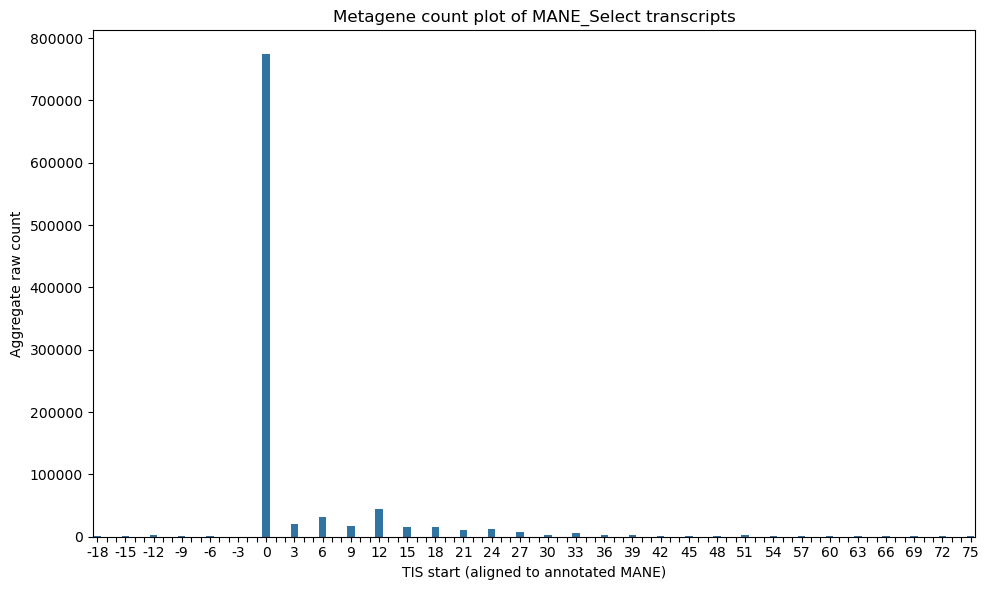

In [87]:
min_lim = -18
max_lim = 75
count_col = 'raw_count'

df_to_plot = aligned_tis_df[
    (aligned_tis_df['aligned_start'] >= min_lim) &
    (aligned_tis_df['aligned_start'] <= max_lim)
].groupby('aligned_start')[count_col].sum().reset_index()
df_to_plot = df_to_plot.merge(
    pd.Series(0, index=np.arange(min_lim, max_lim + 1), name='pseudocount'),
    left_on=['aligned_start'], right_index=True, how='outer'
).sort_values('aligned_start')
df_to_plot['count'] = df_to_plot[count_col].fillna(0) + df_to_plot['pseudocount']

plt.figure(figsize=(10, 6))
sns.barplot(
    df_to_plot, x='aligned_start', y='count'
)
plt.xlabel('TIS start (aligned to annotated MANE)')
plt.ylabel('Aggregate raw count')
plt.title('Metagene count plot of MANE_Select transcripts')
xticklabels = plt.gca().get_xticklabels()
keep_idxs = [str(int(x)) for x in np.arange(min_lim, max_lim+1, step=3)]
for t in xticklabels:
    if t.get_text() not in keep_idxs:
        t.set_text('')
plt.gca().set_xticklabels(xticklabels)
# plt.gca().set_yscale('log', base=10)
plt.tight_layout()
plt.savefig('figures/HeLa_mane_metagene_countplot.png', bbox_inches='tight')

/tmp/ipykernel_2883034/3987792294.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(xticklabels)


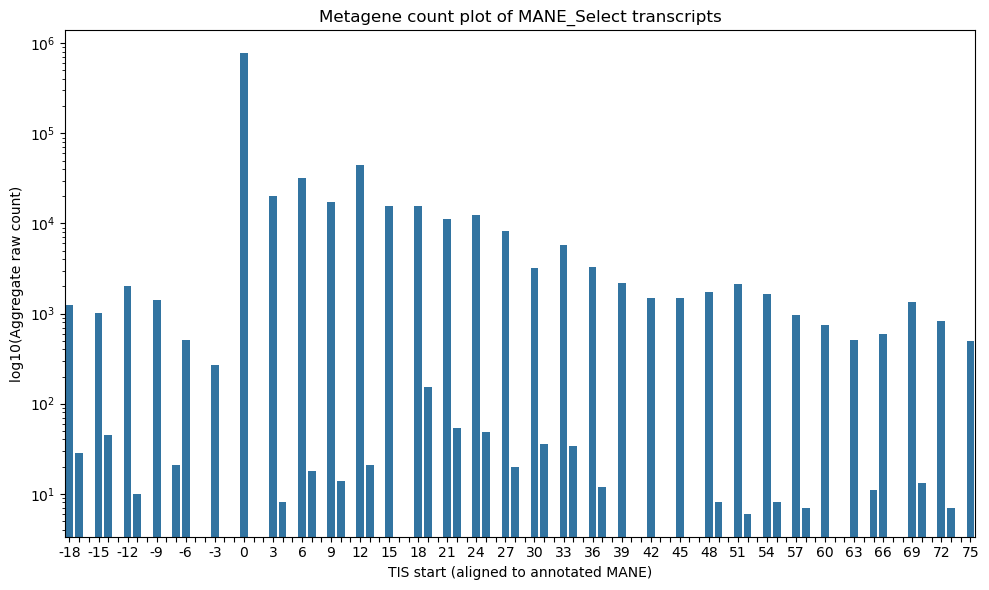

In [86]:
min_lim = -18
max_lim = 75
count_col = 'raw_count'

df_to_plot = aligned_tis_df[
    (aligned_tis_df['aligned_start'] >= min_lim) &
    (aligned_tis_df['aligned_start'] <= max_lim)
].groupby('aligned_start')[count_col].sum().reset_index()
df_to_plot = df_to_plot.merge(
    pd.Series(0, index=np.arange(min_lim, max_lim + 1), name='pseudocount'),
    left_on=['aligned_start'], right_index=True, how='outer'
).sort_values('aligned_start')
df_to_plot['count'] = df_to_plot[count_col].fillna(0) + df_to_plot['pseudocount']

plt.figure(figsize=(10, 6))
sns.barplot(
    df_to_plot, x='aligned_start', y='count'
)
plt.xlabel('TIS start (aligned to annotated MANE)')
plt.ylabel('log10(Aggregate raw count)')
plt.title('Metagene count plot of MANE_Select transcripts')
xticklabels = plt.gca().get_xticklabels()
keep_idxs = [str(int(x)) for x in np.arange(min_lim, max_lim+1, step=3)]
for t in xticklabels:
    if t.get_text() not in keep_idxs:
        t.set_text('')
plt.gca().set_xticklabels(xticklabels)
plt.gca().set_yscale('log', base=10)
plt.tight_layout()
plt.savefig('figures/HeLa_mane_metagene_log_countplot.png', bbox_inches='tight')

/tmp/ipykernel_2883034/4273993166.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(xticklabels)


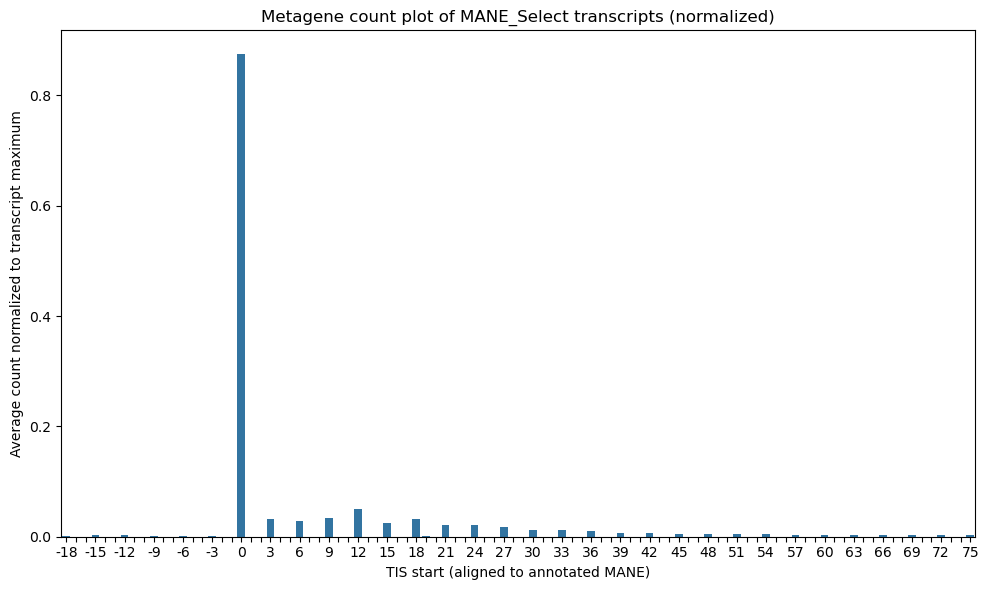

In [85]:
min_lim = -18
max_lim = 75
count_col = 'count_norm_to_max'

df_to_plot = aligned_tis_df[
    (aligned_tis_df['aligned_start'] >= min_lim) &
    (aligned_tis_df['aligned_start'] <= max_lim)
].groupby('aligned_start')[count_col].sum()
df_to_plot = (df_to_plot / len(aligned_tis_df['Tid'].unique().tolist())).reset_index()
df_to_plot = df_to_plot.merge(
    pd.Series(0, index=np.arange(min_lim, max_lim + 1), name='pseudocount'),
    left_on=['aligned_start'], right_index=True, how='outer'
).sort_values('aligned_start')
df_to_plot['count'] = df_to_plot[count_col].fillna(0) + df_to_plot['pseudocount']

plt.figure(figsize=(10, 6))
sns.barplot(
    df_to_plot, x='aligned_start', y='count'
)
plt.xlabel('TIS start (aligned to annotated MANE)')
plt.ylabel('Average count normalized to transcript maximum')
plt.title('Metagene count plot of MANE_Select transcripts (normalized)')
xticklabels = plt.gca().get_xticklabels()
keep_idxs = [str(int(x)) for x in np.arange(min_lim, max_lim+1, step=3)]
for t in xticklabels:
    if t.get_text() not in keep_idxs:
        t.set_text('')
plt.gca().set_xticklabels(xticklabels)
plt.tight_layout()
plt.savefig('figures/HeLa_mane_metagene_norm_countplot.png', bbox_inches='tight')

/tmp/ipykernel_2883034/1734298887.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(xticklabels)


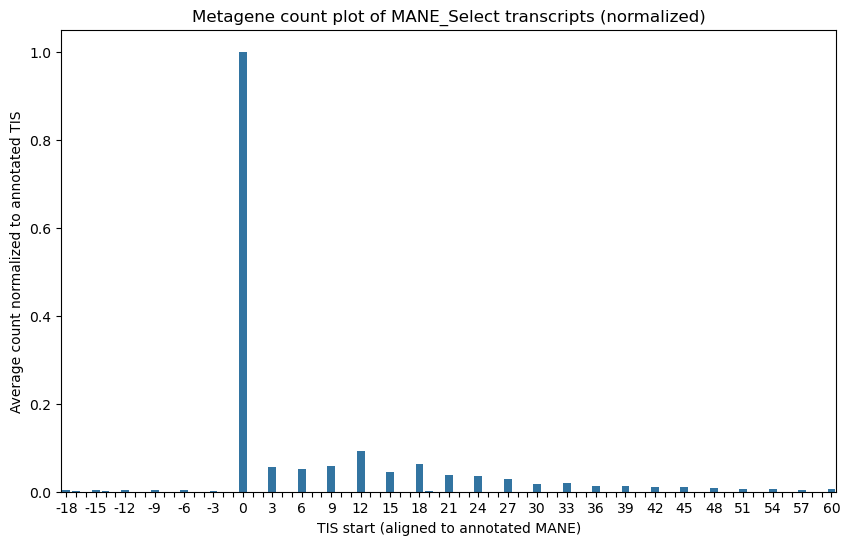

In [74]:
min_lim = -18
max_lim = 60
count_col = 'count_norm_to_annotated'

df_to_plot = aligned_tis_df[
    (aligned_tis_df['aligned_start'] >= min_lim) &
    (aligned_tis_df['aligned_start'] <= max_lim)
].groupby('aligned_start')[count_col].sum()
df_to_plot = (df_to_plot / len(aligned_tis_df['Tid'].unique().tolist())).reset_index()
df_to_plot = df_to_plot.merge(
    pd.Series(0, index=np.arange(min_lim, max_lim + 1), name='pseudocount'),
    left_on=['aligned_start'], right_index=True, how='outer'
).sort_values('aligned_start')
df_to_plot['count'] = df_to_plot[count_col].fillna(0) + df_to_plot['pseudocount']

plt.figure(figsize=(10, 6))
sns.barplot(
    df_to_plot, x='aligned_start', y='count'
)
plt.xlabel('TIS start (aligned to annotated MANE)')
plt.ylabel('Average count normalized to annotated TIS')
plt.title('Metagene count plot of MANE_Select transcripts (normalized)')
xticklabels = plt.gca().get_xticklabels()
keep_idxs = [str(int(x)) for x in np.arange(min_lim, max_lim+1, step=3)]
for t in xticklabels:
    if t.get_text() not in keep_idxs:
        t.set_text('')
plt.gca().set_xticklabels(xticklabels)
plt.show()

<Axes: xlabel='aligned_start', ylabel='raw_count'>

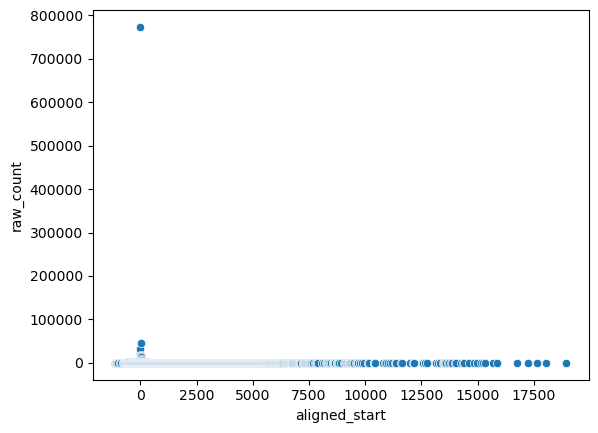

In [117]:
sns.scatterplot(
    aligned_tis_df.groupby('aligned_start')[count_col].sum().reset_index(),
    x='aligned_start', y='raw_count'
)

/tmp/ipykernel_2943611/3229601699.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(xticklabels)


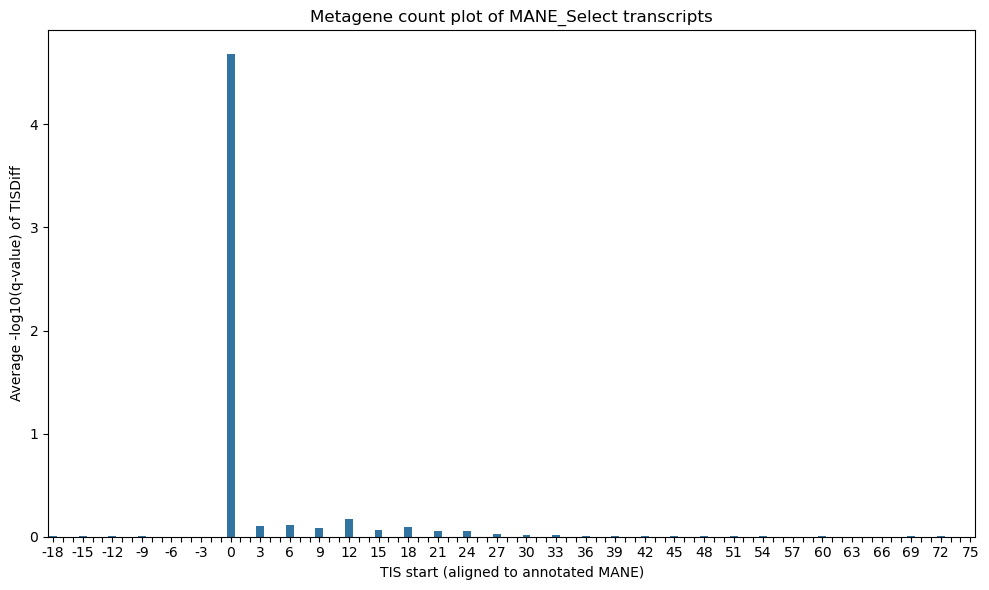

In [142]:
min_lim = -18
max_lim = 75
count_col = 'TISQvalue'

df_to_plot = aligned_tis_df[
    (aligned_tis_df['aligned_start'] >= min_lim) &
    (aligned_tis_df['aligned_start'] <= max_lim)
].assign(calc=lambda x: -np.log10(x[count_col])).groupby('aligned_start')['calc'].sum()
df_to_plot = (df_to_plot / len(aligned_tis_df['Tid'].unique().tolist())).reset_index()
df_to_plot = df_to_plot.merge(
    pd.Series(0, index=np.arange(min_lim, max_lim + 1), name='pseudocount'),
    left_on=['aligned_start'], right_index=True, how='outer'
).sort_values('aligned_start')
df_to_plot['count'] = df_to_plot['calc'].fillna(0) + df_to_plot['pseudocount']

plt.figure(figsize=(10, 6))
sns.barplot(
    df_to_plot, x='aligned_start', y='count'
)
plt.xlabel('TIS start (aligned to annotated MANE)')
plt.ylabel('Average -log10(q-value) of TISDiff')
plt.title('Metagene count plot of MANE_Select transcripts')
xticklabels = plt.gca().get_xticklabels()
keep_idxs = [str(int(x)) for x in np.arange(min_lim, max_lim+1, step=3)]
for t in xticklabels:
    if t.get_text() not in keep_idxs:
        t.set_text('')
plt.gca().set_xticklabels(xticklabels)
# plt.gca().set_yscale('log', base=10)
plt.tight_layout()
plt.show()

In [ ]:
mane_select_annotations = (
    annotated_tis_df['MANE_Select'] & annotated_tis_df['TisType'].str.contains('Annotated')
)

In [100]:
truncation_annotations = (
    annotated_tis_df['MANE_Select'] & annotated_tis_df['RecatTISType'].str.contains('Truncated')
)
trunc_transcript_ids = annotated_tis_df[truncation_annotations]['Tid'].unique().tolist()
trunc_aligned_tis_df = []
tid_groups = annotated_tis_df.groupby('Tid').groups
for tid in tqdm(trunc_transcript_ids):
    subset = annotated_tis_df.loc[tid_groups[tid]]
    annotated = subset[subset['TisType'].str.contains('Truncated')]
    annotated_start = annotated['Start'].iloc[0]
    annotated_count = annotated['TISCounts'].iloc[0]

    subset['aligned_start'] = subset['Start'] - annotated_start
    subset['raw_count'] = subset['TISCounts']
    subset['max_transcript_count'] = subset['TISCounts'].max()
    subset['annotated_count'] = annotated_count
    subset['count_norm_to_max'] = subset['TISCounts'] / subset['TISCounts'].max()
    subset['count_norm_to_annotated'] = subset['TISCounts'] / annotated_count

    trunc_aligned_tis_df.append(subset.loc[:, cols])
trunc_aligned_tis_df = pd.concat(trunc_aligned_tis_df, axis=0)

100%|██████████| 6497/6497 [00:23<00:00, 277.60it/s]


In [99]:
extension_annotations = (
    annotated_tis_df['MANE_Select'] & annotated_tis_df['RecatTISType'].str.contains('Extended')
)
ext_transcript_ids = annotated_tis_df[extension_annotations]['Tid'].unique().tolist()
ext_aligned_tis_df = []
tid_groups = annotated_tis_df.groupby('Tid').groups
for tid in tqdm(ext_transcript_ids):
    subset = annotated_tis_df.loc[tid_groups[tid]]
    annotated = subset[subset['TisType'].str.contains('Extended')]
    annotated_start = annotated['Start'].iloc[0]
    annotated_count = annotated['TISCounts'].iloc[0]

    subset['aligned_start'] = subset['Start'] - annotated_start
    subset['raw_count'] = subset['TISCounts']
    subset['max_transcript_count'] = subset['TISCounts'].max()
    subset['annotated_count'] = annotated_count
    subset['count_norm_to_max'] = subset['TISCounts'] / subset['TISCounts'].max()
    subset['count_norm_to_annotated'] = subset['TISCounts'] / annotated_count

    ext_aligned_tis_df.append(subset.loc[:, cols])
ext_aligned_tis_df = pd.concat(ext_aligned_tis_df, axis=0)

100%|██████████| 1891/1891 [00:06<00:00, 277.22it/s]


/tmp/ipykernel_2883034/3213856024.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(xticklabels)


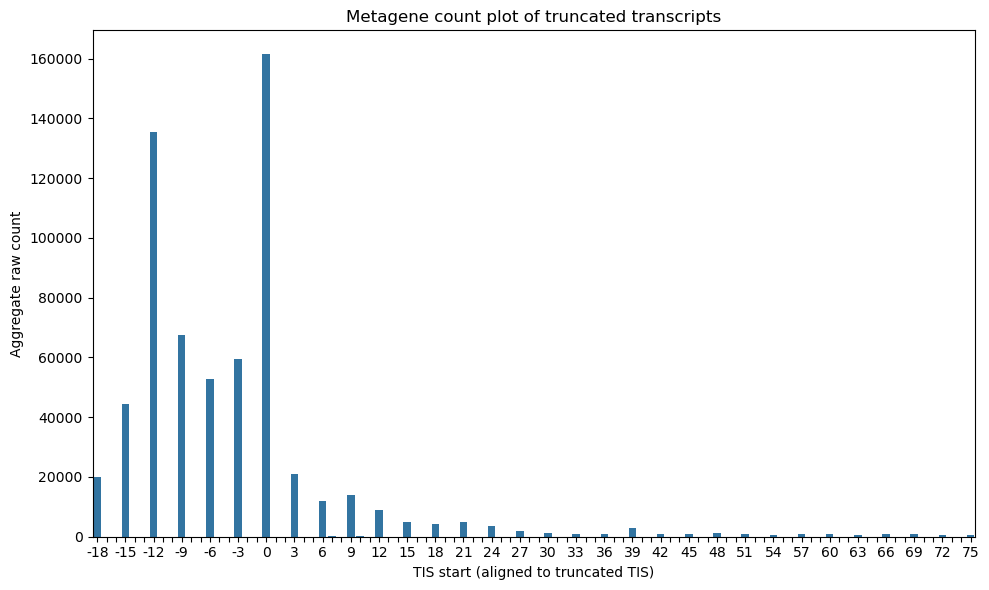

In [112]:
min_lim = -18
max_lim = 75
count_col = 'raw_count'

df_to_plot = trunc_aligned_tis_df[
    (trunc_aligned_tis_df['aligned_start'] >= min_lim) &
    (trunc_aligned_tis_df['aligned_start'] <= max_lim)
].groupby('aligned_start')[count_col].sum().reset_index()
df_to_plot = df_to_plot.merge(
    pd.Series(0, index=np.arange(min_lim, max_lim + 1), name='pseudocount'),
    left_on=['aligned_start'], right_index=True, how='outer'
).sort_values('aligned_start')
df_to_plot['count'] = df_to_plot[count_col].fillna(0) + df_to_plot['pseudocount']

plt.figure(figsize=(10, 6))
sns.barplot(
    df_to_plot, x='aligned_start', y='count'
)
plt.xlabel('TIS start (aligned to truncated TIS)')
plt.ylabel('Aggregate raw count')
plt.title('Metagene count plot of truncated transcripts')
xticklabels = plt.gca().get_xticklabels()
keep_idxs = [str(int(x)) for x in np.arange(min_lim, max_lim+1, step=3)]
for t in xticklabels:
    if t.get_text() not in keep_idxs:
        t.set_text('')
plt.gca().set_xticklabels(xticklabels)
# plt.gca().set_yscale('log', base=10)
plt.tight_layout()
plt.savefig('figures/HeLa_trunc_metagene_countplot.png', bbox_inches='tight')

/tmp/ipykernel_2883034/2115801699.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(xticklabels)


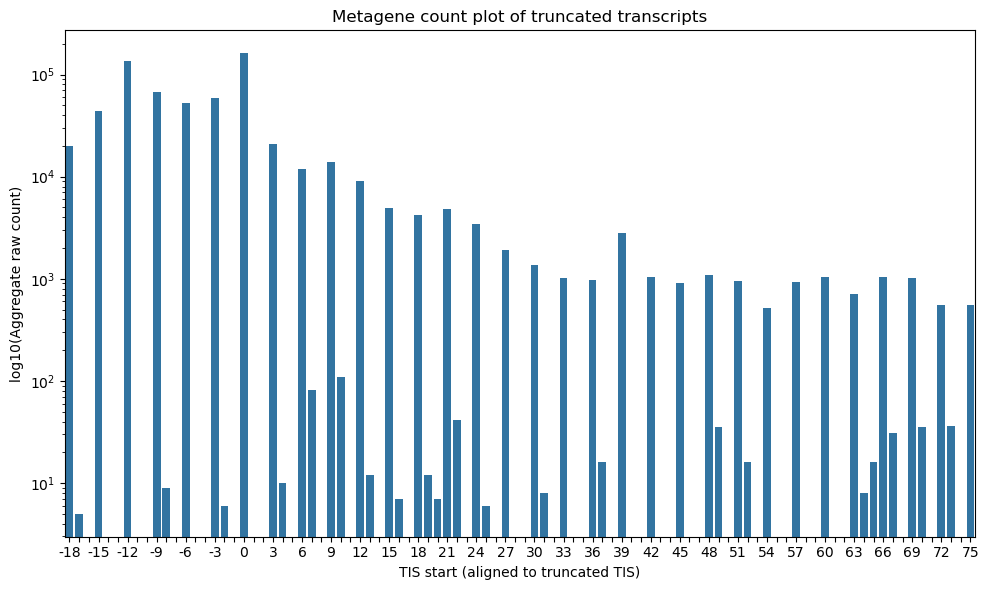

In [108]:
min_lim = -18
max_lim = 75
count_col = 'raw_count'

df_to_plot = trunc_aligned_tis_df[
    (trunc_aligned_tis_df['aligned_start'] >= min_lim) &
    (trunc_aligned_tis_df['aligned_start'] <= max_lim)
].groupby('aligned_start')[count_col].sum().reset_index()
df_to_plot = df_to_plot.merge(
    pd.Series(0, index=np.arange(min_lim, max_lim + 1), name='pseudocount'),
    left_on=['aligned_start'], right_index=True, how='outer'
).sort_values('aligned_start')
df_to_plot['count'] = df_to_plot[count_col].fillna(0) + df_to_plot['pseudocount']

plt.figure(figsize=(10, 6))
sns.barplot(
    df_to_plot, x='aligned_start', y='count'
)
plt.xlabel('TIS start (aligned to truncated TIS)')
plt.ylabel('log10(Aggregate raw count)')
plt.title('Metagene count plot of truncated transcripts')
xticklabels = plt.gca().get_xticklabels()
keep_idxs = [str(int(x)) for x in np.arange(min_lim, max_lim+1, step=3)]
for t in xticklabels:
    if t.get_text() not in keep_idxs:
        t.set_text('')
plt.gca().set_xticklabels(xticklabels)
plt.gca().set_yscale('log', base=10)
plt.tight_layout()
# plt.savefig('figures/HeLa_mane_metagene_countplot.png', bbox_inches='tight')

/tmp/ipykernel_2883034/3800718349.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(xticklabels)


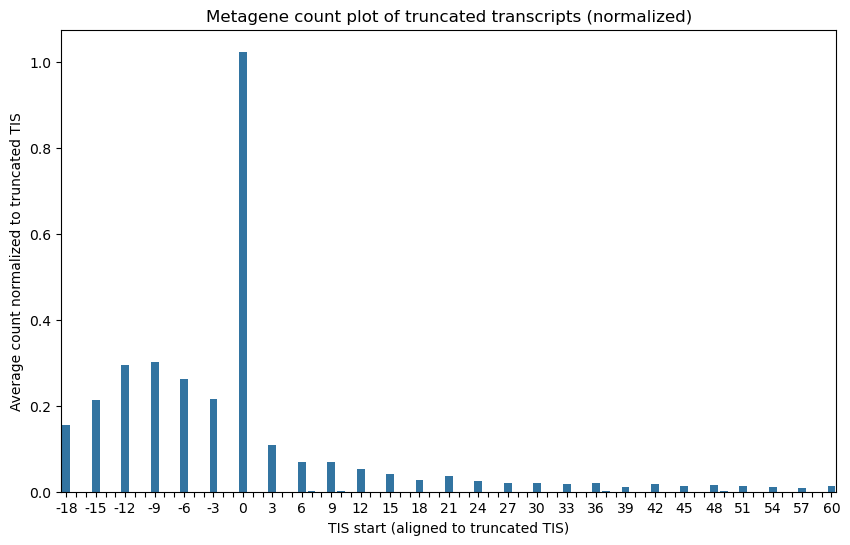

In [110]:
min_lim = -18
max_lim = 60
count_col = 'count_norm_to_annotated'

df_to_plot = trunc_aligned_tis_df[
    (trunc_aligned_tis_df['aligned_start'] >= min_lim) &
    (trunc_aligned_tis_df['aligned_start'] <= max_lim)
].groupby('aligned_start')[count_col].sum()
df_to_plot = (df_to_plot / len(aligned_tis_df['Tid'].unique().tolist())).reset_index()
df_to_plot = df_to_plot.merge(
    pd.Series(0, index=np.arange(min_lim, max_lim + 1), name='pseudocount'),
    left_on=['aligned_start'], right_index=True, how='outer'
).sort_values('aligned_start')
df_to_plot['count'] = df_to_plot[count_col].fillna(0) + df_to_plot['pseudocount']

plt.figure(figsize=(10, 6))
sns.barplot(
    df_to_plot, x='aligned_start', y='count'
)
plt.xlabel('TIS start (aligned to truncated TIS)')
plt.ylabel('Average count normalized to truncated TIS')
plt.title('Metagene count plot of truncated transcripts (normalized)')
xticklabels = plt.gca().get_xticklabels()
keep_idxs = [str(int(x)) for x in np.arange(min_lim, max_lim+1, step=3)]
for t in xticklabels:
    if t.get_text() not in keep_idxs:
        t.set_text('')
plt.gca().set_xticklabels(xticklabels)
plt.show()

/tmp/ipykernel_2883034/825613355.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(xticklabels)


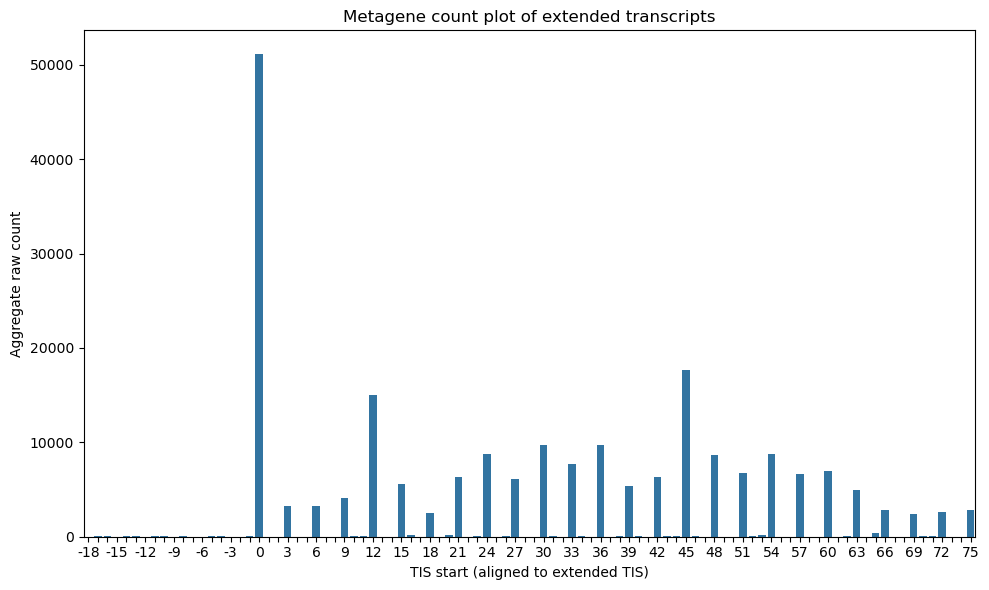

In [107]:
min_lim = -18
max_lim = 75
count_col = 'raw_count'

df_to_plot = ext_aligned_tis_df[
    (ext_aligned_tis_df['aligned_start'] >= min_lim) &
    (ext_aligned_tis_df['aligned_start'] <= max_lim)
].groupby('aligned_start')[count_col].sum().reset_index()
df_to_plot = df_to_plot.merge(
    pd.Series(0, index=np.arange(min_lim, max_lim + 1), name='pseudocount'),
    left_on=['aligned_start'], right_index=True, how='outer'
).sort_values('aligned_start')
df_to_plot['count'] = df_to_plot[count_col].fillna(0) + df_to_plot['pseudocount']

plt.figure(figsize=(10, 6))
sns.barplot(
    df_to_plot, x='aligned_start', y='count'
)
plt.xlabel('TIS start (aligned to extended TIS)')
plt.ylabel('Aggregate raw count')
plt.title('Metagene count plot of extended transcripts')
xticklabels = plt.gca().get_xticklabels()
keep_idxs = [str(int(x)) for x in np.arange(min_lim, max_lim+1, step=3)]
for t in xticklabels:
    if t.get_text() not in keep_idxs:
        t.set_text('')
plt.gca().set_xticklabels(xticklabels)
# plt.gca().set_yscale('log', base=10)
plt.tight_layout()
# plt.savefig('figures/HeLa_mane_metagene_countplot.png', bbox_inches='tight')

/tmp/ipykernel_2883034/3625056135.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(xticklabels)


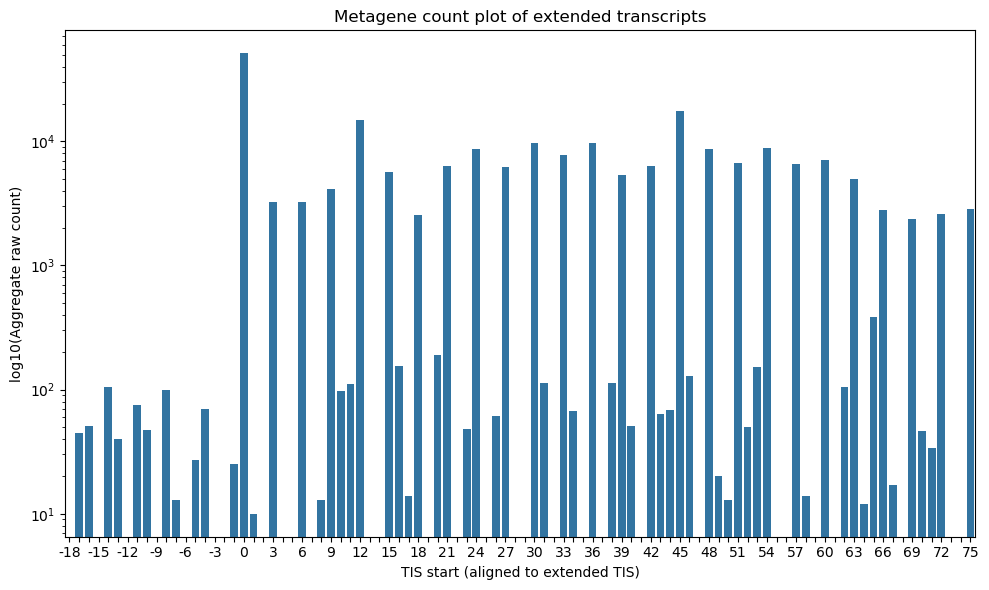

In [106]:
min_lim = -18
max_lim = 75
count_col = 'raw_count'

df_to_plot = ext_aligned_tis_df[
    (ext_aligned_tis_df['aligned_start'] >= min_lim) &
    (ext_aligned_tis_df['aligned_start'] <= max_lim)
].groupby('aligned_start')[count_col].sum().reset_index()
df_to_plot = df_to_plot.merge(
    pd.Series(0, index=np.arange(min_lim, max_lim + 1), name='pseudocount'),
    left_on=['aligned_start'], right_index=True, how='outer'
).sort_values('aligned_start')
df_to_plot['count'] = df_to_plot[count_col].fillna(0) + df_to_plot['pseudocount']

plt.figure(figsize=(10, 6))
sns.barplot(
    df_to_plot, x='aligned_start', y='count'
)
plt.xlabel('TIS start (aligned to extended TIS)')
plt.ylabel('log10(Aggregate raw count)')
plt.title('Metagene count plot of extended transcripts')
xticklabels = plt.gca().get_xticklabels()
keep_idxs = [str(int(x)) for x in np.arange(min_lim, max_lim+1, step=3)]
for t in xticklabels:
    if t.get_text() not in keep_idxs:
        t.set_text('')
plt.gca().set_xticklabels(xticklabels)
plt.gca().set_yscale('log', base=10)
plt.tight_layout()
# plt.savefig('figures/HeLa_mane_metagene_countplot.png', bbox_inches='tight')

/tmp/ipykernel_2883034/4124331744.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(xticklabels)


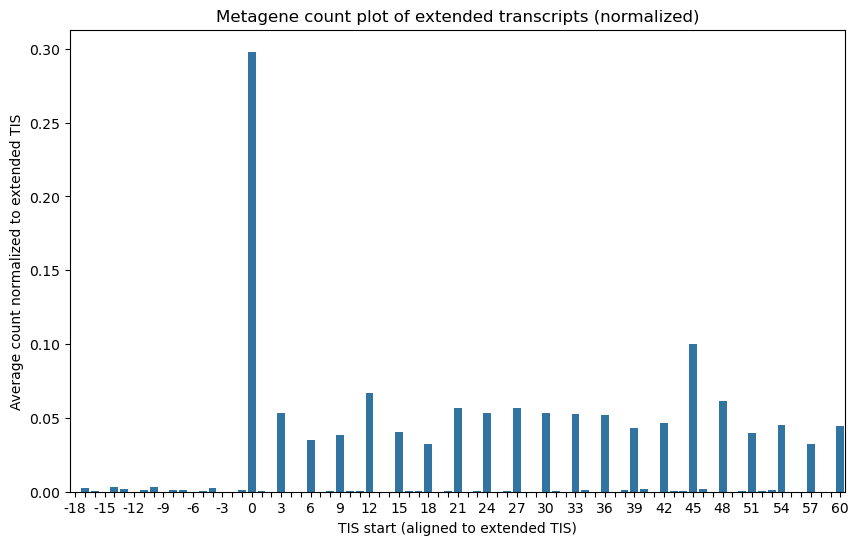

In [111]:
min_lim = -18
max_lim = 60
count_col = 'count_norm_to_annotated'

df_to_plot = ext_aligned_tis_df[
    (ext_aligned_tis_df['aligned_start'] >= min_lim) &
    (ext_aligned_tis_df['aligned_start'] <= max_lim)
].groupby('aligned_start')[count_col].sum()
df_to_plot = (df_to_plot / len(aligned_tis_df['Tid'].unique().tolist())).reset_index()
df_to_plot = df_to_plot.merge(
    pd.Series(0, index=np.arange(min_lim, max_lim + 1), name='pseudocount'),
    left_on=['aligned_start'], right_index=True, how='outer'
).sort_values('aligned_start')
df_to_plot['count'] = df_to_plot[count_col].fillna(0) + df_to_plot['pseudocount']

plt.figure(figsize=(10, 6))
sns.barplot(
    df_to_plot, x='aligned_start', y='count'
)
plt.xlabel('TIS start (aligned to extended TIS)')
plt.ylabel('Average count normalized to extended TIS')
plt.title('Metagene count plot of extended transcripts (normalized)')
xticklabels = plt.gca().get_xticklabels()
keep_idxs = [str(int(x)) for x in np.arange(min_lim, max_lim+1, step=3)]
for t in xticklabels:
    if t.get_text() not in keep_idxs:
        t.set_text('')
plt.gca().set_xticklabels(xticklabels)
plt.show()

In [123]:
filtered_tis_df['TisType'].str.contains("Annotated").sum()

np.int64(8774)

In [124]:
filtered_tis_df['TisType'].str.contains("Truncated").sum()

np.int64(12656)

In [122]:
filtered_tis_df['TisType'].str.contains("5'UTR").sum()

np.int64(914)

In [125]:
filtered_tis_df['TisType'].str.contains("Extended").sum()

np.int64(2441)

# Experiment with filtering

In [95]:
mane_transcripts = annotated_tis_df[annotated_tis_df['MANE_Select']]['Tid'].unique().tolist()
mane_subset = annotated_tis_df[annotated_tis_df['Tid'].isin(mane_transcripts)]
annotated_start_sites = mane_subset[mane_subset['RecatTISType'] == 'Annotated']

In [96]:
annotated_start_sites['count_rank'] = annotated_start_sites['TISCounts'].rank(method='max') 
annotated_start_sites['quantile'] = annotated_start_sites['count_rank'] / len(annotated_start_sites)

(0.0, 20.0)

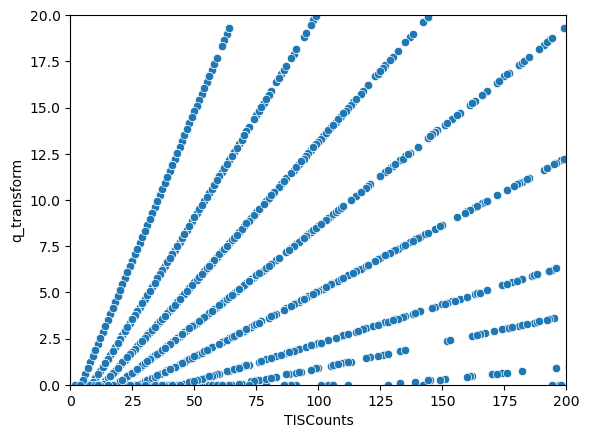

In [112]:
sns.scatterplot(annotated_start_sites.assign(q_transform=lambda x: -np.log10(x['TISQvalue'])), x='TISCounts', y='q_transform')
plt.xlim(0, 200)
plt.ylim(0, 20)

(0.0, 100.0)

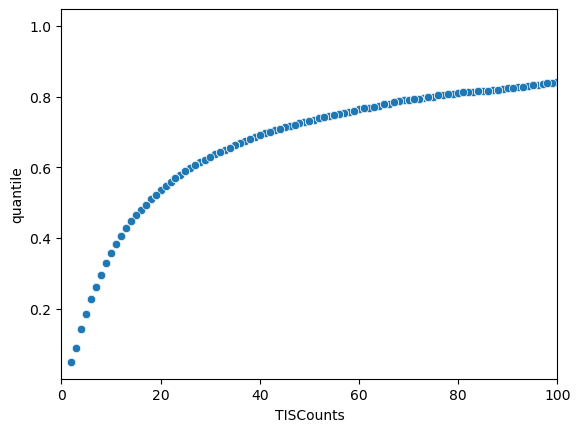

In [120]:
sns.scatterplot(annotated_start_sites, x='TISCounts', y='quantile')
plt.xlim(0, 100)

In [114]:
annotated_start_sites[annotated_start_sites['quantile'] <= 0.25]['TISCounts'].max()

np.int64(6)

In [115]:
mane_subset[
    mane_subset['TISCounts'] > 
    annotated_start_sites[annotated_start_sites['quantile'] <= 0.25]['TISCounts'].max()
].value_counts('RecatTISType')

RecatTISType
Truncated    7387
Annotated    4910
Extended     1765
uORF         1286
Other         139
Name: count, dtype: int64

In [117]:
mane_subset.groupby('Tid')['Start'].count().sort_values(ascending=False).head(20)

Tid
ENST00000378024.9     35
ENST00000264170.9     35
ENST00000263857.11    33
ENST00000229214.9     32
ENST00000361354.9     30
ENST00000359062.4     29
ENST00000372146.5     29
ENST00000650182.1     29
ENST00000685211.1     28
ENST00000308488.11    27
ENST00000394518.7     27
ENST00000605930.3     27
ENST00000355528.9     27
ENST00000319562.11    26
ENST00000220592.10    26
ENST00000615648.2     26
ENST00000439151.7     25
ENST00000276440.12    25
ENST00000262043.8     24
ENST00000380079.9     24
Name: Start, dtype: int64

<Axes: xlabel='Start', ylabel='TISCounts'>

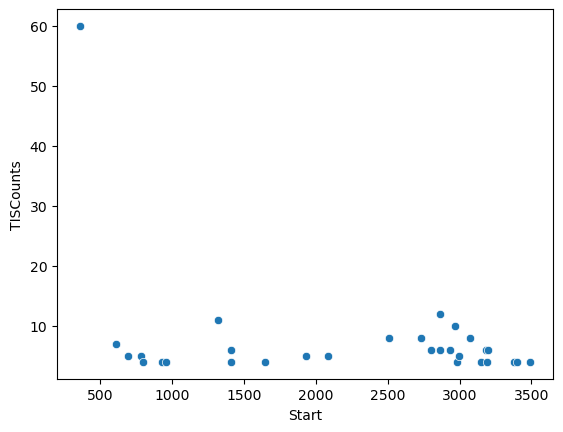

In [118]:
sns.scatterplot(
    mane_subset[mane_subset['Tid'] == 'ENST00000361354.9'].sort_values('Start'),
    x='Start',
    y='TISCounts'
)

<Axes: xlabel='Start', ylabel='TISCounts'>

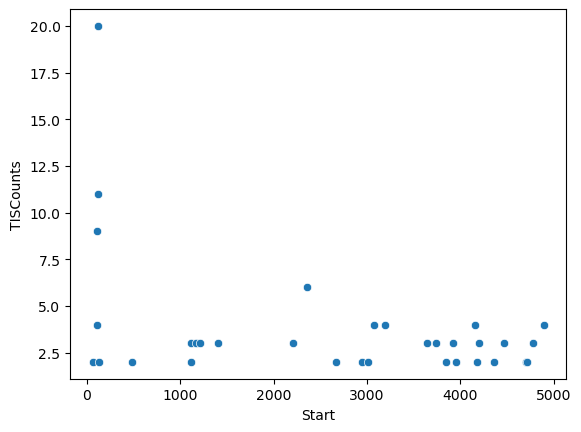

In [119]:
sns.scatterplot(
    mane_subset[mane_subset['Tid'] == 'ENST00000263857.11'].sort_values('Start'),
    x='Start',
    y='TISCounts'
)

In [176]:
gradient_df_reference = aligned_tis_df.sort_values(['Tid', 'aligned_start'])
neighbor_mask = gradient_df_reference['aligned_start'].diff() == 3
gradient_df = gradient_df_reference[neighbor_mask]
gradient_df['count_diff'] = gradient_df_reference['raw_count'].diff()[neighbor_mask]
gradient_df['count_ratio_diff'] = gradient_df_reference['raw_count'].pct_change()[neighbor_mask]
gradient_df['qval_log_diff'] = (-np.log10(gradient_df_reference['TISQvalue'])).diff()[neighbor_mask]
gradient_df['qval_log_ratio_diff'] = (-np.log10(gradient_df_reference['TISQvalue'])).pct_change()[neighbor_mask]
gradient_df['prior_count'] = gradient_df['raw_count'] - gradient_df['count_diff']

(-100.0, 100.0)

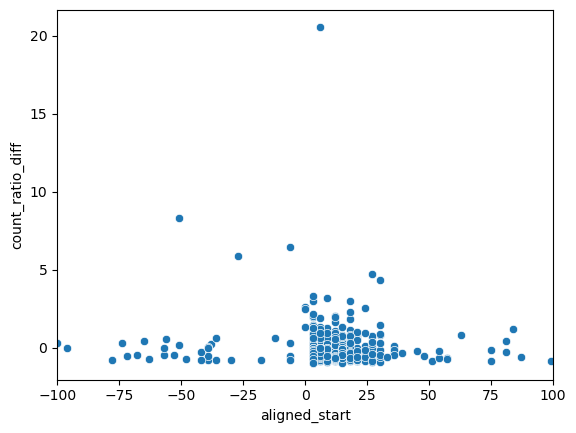

In [177]:
sns.scatterplot(gradient_df[gradient_df['prior_count'] > 17], x='aligned_start', y='count_ratio_diff')
plt.xlim(-100, 100)

In [178]:
gradient_df[gradient_df['prior_count'] > 17].sort_values('count_ratio_diff', ascending=False)

,Gid,Tid,Symbol,StartCodon,Start,TisType,TISGroup,TISQvalue,GenomePos,chromosome,...,raw_count,max_transcript_count,annotated_count,count_norm_to_max,count_norm_to_annotated,count_diff,count_ratio_diff,qval_log_diff,qval_log_ratio_diff,prior_count
117183,ENSG00000145592.15,ENST00000274242.10,RPL37,AAG,43,Truncated,7,2.856820e-88,chr5:40832503-40834603:-,chr5,...,6189,6189,463,1.000000,13.367171,5902.0,20.564460,85.363664,39.149501,287.0
245951,ENSG00000167553.18,ENST00000301072.11,TUBA1C,TTG,49,Extended,7,2.706432e-06,chr12:49265130-49273227:+,chr12,...,529,529,392,1.000000,1.349490,472.0,8.280702,5.567603,-inf,57.0
112453,ENSG00000129128.13,ENST00000503362.2,SPCS3,ATC,105,Extended,5,1.082898e-04,chr4:176320070-176328330:+,chr4,...,141,297,222,0.474747,0.635135,122.0,6.421053,3.965412,-inf,19.0
47037,ENSG00000213639.12,ENST00000395366.3,PPP1CB,CTG,268,Extended,4,5.330606e-12,chr2:28752097-28799303:+,chr2,...,186,220,220,0.845455,0.845455,159.0,5.888889,11.273223,-inf,27.0
4429,ENSG00000117118.13,ENST00000375499.8,SDHB,AGG,40,Truncated,6,8.860731e-08,chr1:17018880-17053992:-,chr1,...,314,314,43,1.000000,7.302326,259.0,4.709091,7.052530,-inf,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175252,ENSG00000104325.8,ENST00000220764.7,DECR1,AAG,19,Truncated,1,6.442683e-02,chr8:90001495-90051897:+,chr8,...,14,335,335,0.041791,0.041791,-321.0,-0.958209,-72.053743,-0.983740,335.0
388099,ENSG00000155008.17,ENST00000373173.7,APOOL,ATG,51,Truncated,0,1.000000e+00,chrX:85046445-85087678:+,chrX,...,2,49,19,0.040816,0.105263,-47.0,-0.959184,-14.461753,-1.000000,49.0
142380,ENSG00000112245.14,ENST00000626021.3,PTP4A1,ATT,204,5'UTR:CDSFrameOverlap,6,3.649437e-01,chr6:63572683-63576531:+,chr6,...,83,2073,354,0.040039,0.234463,-1990.0,-0.959961,-59.095245,-0.992647,2073.0
142398,ENSG00000285976.4,ENST00000715520.1,ENSG00000285976,ATT,204,Truncated,6,3.649437e-01,chr6:63572683-63576531:+,chr6,...,83,2073,2073,0.040039,0.040039,-1990.0,-0.959961,-59.095245,-0.992647,2073.0


<Axes: xlabel='count_ratio_diff', ylabel='Density'>

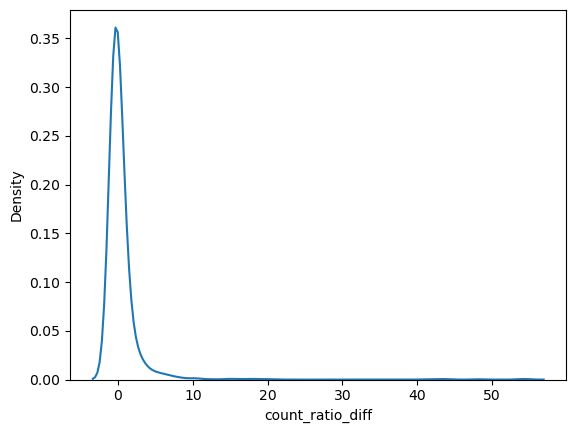

In [152]:
sns.kdeplot(gradient_df, x='count_ratio_diff')

<Axes: xlabel='qval_log_diff', ylabel='Density'>

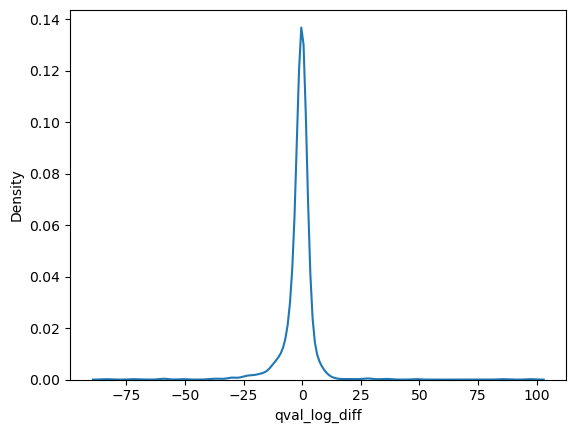

In [180]:
sns.kdeplot(gradient_df, x='qval_log_diff')

In [187]:
gradient_df['qval_log_diff'].quantile(0.95)

np.float64(4.322061256234753)

In [9]:
def alternative_filter_ribotish_results(
    tis_df, 
    transcript_support_levels=['1','2','3'], 
    min_tis_counts=None,
    min_percentile_tis_counts=90,
    min_putative_tis_counts=6, # 6 is estimated from the 25th percentile counts of annotated MANE start sites
    peak_qval_magnitude=4, # 4 is estimated from 95th percentile of qvalue change for all OBSERVED neighbor TIS pairs
):
    reference_tids = identify_reference_transcripts(
        tis_df, 
        transcript_support_levels=transcript_support_levels,
        min_tis_counts=min_tis_counts,
        min_percentile_tis_counts=min_percentile_tis_counts
    )

    print(f'Identified {len(reference_tids)} transcript IDs to use...')
    reference_mask = tis_df['Tid'].isin(reference_tids)
    print(f'{reference_mask.sum()} TISs are mapped to these transcript IDs...')
    reference_tis_df = tis_df[reference_mask]
    reference_tis_df = reference_tis_df.sort_values(['Tid', 'Start'])
    preceded_mask = reference_tis_df['Start'].diff() == 3
    reference_tis_df['preceded'] = preceded_mask
    reference_tis_df['count_diff'] = reference_tis_df['TISCounts']
    reference_tis_df.loc[preceded_mask, 'count_diff'] = reference_tis_df['TISCounts'].diff()[preceded_mask]
    reference_tis_df['log_qval_diff'] = -np.log10(reference_tis_df['TISQvalue'])
    reference_tis_df.loc[preceded_mask, 'log_qval_diff'] = (-np.log10(reference_tis_df['TISQvalue'])).diff()[preceded_mask]

    tis_to_keep = []
    for tid, idxs in tqdm(reference_tis_df.groupby('Tid').groups.items()):
        subset = reference_tis_df.loc[idxs, :].sort_values(['Start'], ascending=False)
        # always accept the annotated start site
        annotated_mask = subset['TisType'].str.contains('Annotated')
        tis_to_keep.append(subset[annotated_mask])
        subset = subset[~annotated_mask].reset_index(drop=True).copy()

        current_peak_i = None
        for i, r in subset.iterrows():
            if r['preceded']: # continuity, logic of peak finding depends on the prior state
                if current_peak_i is not None: # we already called a peak
                    if r['count_diff'] >= 0: # if the count continues to increase, update the tracker to the endmost peak
                        current_peak_i = i
                    else: # otherwise, add the putative peak and reset the tracker
                        tis_to_keep.append(subset[subset.index == current_peak_i]) 
                        current_peak_i = None
                else: # we have not previously called a peak
                    if (r['TISCounts'] >= min_putative_tis_counts) and (r['log_qval_diff'] >= peak_qval_magnitude): # found a new peak
                        current_peak_i = i
            else: # no continuity, logic of peak finding is decoupled from the prior state
                if current_peak_i is not None: # add the last found peak and reset the tracker since the current position is irrelevant to the peak determination of the last
                    tis_to_keep.append(subset[subset.index == current_peak_i])
                    current_peak_i = None
                if (r['TISCounts'] >= min_putative_tis_counts) and (r['log_qval_diff'] >= peak_qval_magnitude): # found a new peak
                    current_peak_i = i
                
        if current_peak_i is not None:
            tis_to_keep.append(subset[subset.index == current_peak_i])

    filtered_tis_df = pd.concat(tis_to_keep, axis=0)
    print(f'Keeping {filtered_tis_df.shape[0]} TISs from reference transcripts, using a peak finding algorithm that selects TIS with at least {min_putative_tis_counts} counts and a 10^{peak_qval_magnitude} increase in TISDiff significance from the prior position')
    return filtered_tis_df.reset_index(drop=True)

In [227]:
alt_filter_tis_df = alternative_filter_ribotish_results(
    annotated_tis_df,
    transcript_support_levels=['1','2','3'], 
    min_percentile_tis_counts=90,
    min_putative_tis_counts=5,
    peak_qval_magnitude=3,
)

Selecting from 393432 TISs to use...
Keeping 33379 TISs for MANE_Select transcripts
36795 remaining TISs have readcount support >= 63.0...
55480 remaining TISs are transcript support level 1/2/3...
Keeping 6309 TISs with both annotated and empirical support
8778 of these TISs have annotated start sites, representing 8778 unique transcript IDs
Identified 8778 transcript IDs to use...
32266 TISs are mapped to these transcript IDs...


100%|██████████| 8778/8778 [00:32<00:00, 273.60it/s]


Keeping 10114 TISs from reference transcripts, using a peak finding algorithm that selects TIS with at least 5 counts and a 10^3 increase in log(TISDiff significance) from the prior position


In [228]:
filtered_tis_df.value_counts('TisType')

TisType
Truncated                   12422
Annotated                    8774
Extended                     2295
5'UTR                         876
Truncated:Known               234
Extended:CDSFrameOverlap      122
Internal                       82
3'UTR:CDSFrameOverlap          50
5'UTR:CDSFrameOverlap          24
Extended:Known                 24
5'UTR:Known                    14
Internal:CDSFrameOverlap       12
3'UTR                           4
3'UTR:Known                     3
Internal:Known                  2
Name: count, dtype: int64

In [229]:
alt_filter_tis_df.value_counts('TisType')

TisType
Annotated                   8778
Truncated                    602
5'UTR                        376
Extended                     281
Truncated:Known               25
Extended:CDSFrameOverlap      14
Extended:Known                11
5'UTR:Known                    7
5'UTR:CDSFrameOverlap          6
Internal                       6
Internal:CDSFrameOverlap       2
3'UTR:Known                    2
3'UTR                          2
Internal:Known                 1
3'UTR:CDSFrameOverlap          1
Name: count, dtype: int64

In [13]:
trim_columns = [
    'Gid', 'Tid', 'Symbol', 
    'StartCodon', 'Start', 'TisType', 'TISGroup', 'TISCounts', 'TISQvalue', 'count_diff', 'log_qval_diff',
    'GenomePos', 'Seq', 'AASeq', 'feature_type', 'strand', 'frame',
    'gene_type', 'transcript_type', 'transcript_support_level', 'MANE_Select'
]


in_out_dict = {
    '/lab/barcheese01/aTIS_data/ribotish/HeLa_TIS_predict.txt': 'HeLa_TIS_alt_filtered.csv',
    '/lab/barcheese01/aTIS_data/ribotish/K562_TIS_predict.txt': 'K562_TIS_alt_filtered.csv',
    '/lab/barcheese01/aTIS_data/ribotish/RPE1_Async_TIS_predict.txt': 'RPE1_Async_TIS_alt_filtered.csv',
    '/lab/barcheese01/aTIS_data/ribotish/RPE1_Que_TIS_predict.txt': 'RPE1_Que_TIS_alt_filtered.csv',
    '/lab/barcheese01/aTIS_data/ribotish/RPE1_Sen_TIS_predict.txt': 'RPE1_Sen_TIS_alt_filtered.csv',
    '/lab/barcheese01/aTIS_data/ribotish/U2OS_TIS_predict.txt': 'U2OS_TIS_alt_filtered.csv',
}
for input, output in in_out_dict.items():
    print(f'Processing {input}...')
    annotated_tis_df = import_ribotish_results(
        input, 
        gtf_df=gtf_df
    )
    filtered_tis_df = alternative_filter_ribotish_results(
        annotated_tis_df,
        transcript_support_levels=['1','2','3'], 
        min_percentile_tis_counts=90,
        min_putative_tis_counts=5,
        peak_qval_magnitude=2,
    )
    filtered_tis_df.loc[:, trim_columns].to_csv(os.path.join('/lab/barcheese01/smaffa/filtered_tis_data', output), index=False)

Processing /lab/barcheese01/aTIS_data/ribotish/HeLa_TIS_predict.txt...
Selecting from 393432 TISs to use...
Keeping 33379 TISs for MANE_Select transcripts
36795 remaining TISs have readcount support >= 63.0...
55480 remaining TISs are transcript support level 1/2/3...
Keeping 6309 TISs with both annotated and empirical support
8778 of these TISs have annotated start sites, representing 8778 unique transcript IDs
Identified 8778 transcript IDs to use...
32266 TISs are mapped to these transcript IDs...


100%|██████████| 8778/8778 [00:29<00:00, 293.00it/s]


Keeping 10737 TISs from reference transcripts, using a peak finding algorithm that selects TIS with at least 5 counts and a 10^2 increase in log(TISDiff significance) from the prior position
Processing /lab/barcheese01/aTIS_data/ribotish/K562_TIS_predict.txt...
Selecting from 767323 TISs to use...
Keeping 55002 TISs for MANE_Select transcripts
71771 remaining TISs have readcount support >= 116.0...
134922 remaining TISs are transcript support level 1/2/3...
Keeping 13679 TISs with both annotated and empirical support
13240 of these TISs have annotated start sites, representing 13240 unique transcript IDs
Identified 13240 transcript IDs to use...
64959 TISs are mapped to these transcript IDs...


100%|██████████| 13240/13240 [00:52<00:00, 250.36it/s]


Keeping 20015 TISs from reference transcripts, using a peak finding algorithm that selects TIS with at least 5 counts and a 10^2 increase in log(TISDiff significance) from the prior position
Processing /lab/barcheese01/aTIS_data/ribotish/RPE1_Async_TIS_predict.txt...
Selecting from 306616 TISs to use...
Keeping 25442 TISs for MANE_Select transcripts
28629 remaining TISs have readcount support >= 66.0...
41317 remaining TISs are transcript support level 1/2/3...
Keeping 4805 TISs with both annotated and empirical support
7172 of these TISs have annotated start sites, representing 7172 unique transcript IDs
Identified 7172 transcript IDs to use...
25275 TISs are mapped to these transcript IDs...


100%|██████████| 7172/7172 [00:27<00:00, 261.93it/s]


Keeping 10235 TISs from reference transcripts, using a peak finding algorithm that selects TIS with at least 5 counts and a 10^2 increase in log(TISDiff significance) from the prior position
Processing /lab/barcheese01/aTIS_data/ribotish/RPE1_Que_TIS_predict.txt...
Selecting from 519739 TISs to use...
Keeping 39276 TISs for MANE_Select transcripts
49608 remaining TISs have readcount support >= 33.0...
79722 remaining TISs are transcript support level 1/2/3...
Keeping 8535 TISs with both annotated and empirical support
10306 of these TISs have annotated start sites, representing 10306 unique transcript IDs
Identified 10306 transcript IDs to use...
42018 TISs are mapped to these transcript IDs...


/lab/barcheese01/smaffa/miniforge3/envs/riboseq/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 10306/10306 [00:40<00:00, 256.28it/s]


Keeping 15350 TISs from reference transcripts, using a peak finding algorithm that selects TIS with at least 5 counts and a 10^2 increase in log(TISDiff significance) from the prior position
Processing /lab/barcheese01/aTIS_data/ribotish/RPE1_Sen_TIS_predict.txt...
Selecting from 303181 TISs to use...
Keeping 26037 TISs for MANE_Select transcripts
28192 remaining TISs have readcount support >= 69.0...
42818 remaining TISs are transcript support level 1/2/3...
Keeping 4750 TISs with both annotated and empirical support
7293 of these TISs have annotated start sites, representing 7293 unique transcript IDs
Identified 7293 transcript IDs to use...
25700 TISs are mapped to these transcript IDs...


100%|██████████| 7293/7293 [00:26<00:00, 271.90it/s]


Keeping 10198 TISs from reference transcripts, using a peak finding algorithm that selects TIS with at least 5 counts and a 10^2 increase in log(TISDiff significance) from the prior position
Processing /lab/barcheese01/aTIS_data/ribotish/U2OS_TIS_predict.txt...
Selecting from 693027 TISs to use...
Keeping 50968 TISs for MANE_Select transcripts
65503 remaining TISs have readcount support >= 40.0...
105082 remaining TISs are transcript support level 1/2/3...
Keeping 12151 TISs with both annotated and empirical support
11233 of these TISs have annotated start sites, representing 11233 unique transcript IDs
Identified 11233 transcript IDs to use...
56356 TISs are mapped to these transcript IDs...


100%|██████████| 11233/11233 [00:42<00:00, 267.17it/s]


Keeping 13526 TISs from reference transcripts, using a peak finding algorithm that selects TIS with at least 5 counts and a 10^2 increase in log(TISDiff significance) from the prior position


In [10]:
trim_columns = [
    'Gid', 'Tid', 'Symbol', 
    'StartCodon', 'Start', 'TisType', 'TISGroup', 'TISCounts', 'TISQvalue', 'count_diff', 'log_qval_diff',
    'GenomePos', 'Seq', 'AASeq', 'feature_type', 'strand', 'frame',
    'gene_type', 'transcript_type', 'transcript_support_level', 'MANE_Select'
]


in_out_dict = {
    '/lab/barcheese01/aTIS_data/ribotish/HeLa_TIS_predict.txt': 'HeLa_TIS_alt_filtered2.csv',
    '/lab/barcheese01/aTIS_data/ribotish/K562_TIS_predict.txt': 'K562_TIS_alt_filtered2.csv',
    '/lab/barcheese01/aTIS_data/ribotish/RPE1_Async_TIS_predict.txt': 'RPE1_Async_TIS_alt_filtered2.csv',
    '/lab/barcheese01/aTIS_data/ribotish/RPE1_Que_TIS_predict.txt': 'RPE1_Que_TIS_alt_filtered2.csv',
    '/lab/barcheese01/aTIS_data/ribotish/RPE1_Sen_TIS_predict.txt': 'RPE1_Sen_TIS_alt_filtered2.csv',
    '/lab/barcheese01/aTIS_data/ribotish/U2OS_TIS_predict.txt': 'U2OS_TIS_alt_filtered2.csv',
}
for input, output in in_out_dict.items():
    print(f'Processing {input}...')
    annotated_tis_df = import_ribotish_results(
        input, 
        gtf_df=gtf_df
    )
    filtered_tis_df = alternative_filter_ribotish_results(
        annotated_tis_df,
        transcript_support_levels=['1','2','3'], 
        min_percentile_tis_counts=90,
        min_putative_tis_counts=5,
        peak_qval_magnitude=3,
    )
    filtered_tis_df.loc[:, trim_columns].to_csv(os.path.join('/lab/barcheese01/smaffa/filtered_tis_data', output), index=False)

Processing /lab/barcheese01/aTIS_data/ribotish/HeLa_TIS_predict.txt...
Selecting from 393432 TISs to use...
Keeping 33379 TISs for MANE_Select transcripts
36795 remaining TISs have readcount support >= 63.0...
55480 remaining TISs are transcript support level 1/2/3...
Keeping 6309 TISs with both annotated and empirical support
8778 of these TISs have annotated start sites, representing 8778 unique transcript IDs
Identified 8778 transcript IDs to use...
32266 TISs are mapped to these transcript IDs...


100%|██████████| 8778/8778 [00:30<00:00, 286.05it/s]


Keeping 10114 TISs from reference transcripts, using a peak finding algorithm that selects TIS with at least 5 counts and a 10^3 increase in TISDiff significance from the prior position
Processing /lab/barcheese01/aTIS_data/ribotish/K562_TIS_predict.txt...
Selecting from 767323 TISs to use...
Keeping 55002 TISs for MANE_Select transcripts
71771 remaining TISs have readcount support >= 116.0...
134922 remaining TISs are transcript support level 1/2/3...
Keeping 13679 TISs with both annotated and empirical support
13240 of these TISs have annotated start sites, representing 13240 unique transcript IDs
Identified 13240 transcript IDs to use...
64959 TISs are mapped to these transcript IDs...


100%|██████████| 13240/13240 [00:50<00:00, 264.76it/s]


Keeping 17973 TISs from reference transcripts, using a peak finding algorithm that selects TIS with at least 5 counts and a 10^3 increase in TISDiff significance from the prior position
Processing /lab/barcheese01/aTIS_data/ribotish/RPE1_Async_TIS_predict.txt...
Selecting from 306616 TISs to use...
Keeping 25442 TISs for MANE_Select transcripts
28629 remaining TISs have readcount support >= 66.0...
41317 remaining TISs are transcript support level 1/2/3...
Keeping 4805 TISs with both annotated and empirical support
7172 of these TISs have annotated start sites, representing 7172 unique transcript IDs
Identified 7172 transcript IDs to use...
25275 TISs are mapped to these transcript IDs...


100%|██████████| 7172/7172 [00:26<00:00, 270.69it/s]


Keeping 9455 TISs from reference transcripts, using a peak finding algorithm that selects TIS with at least 5 counts and a 10^3 increase in TISDiff significance from the prior position
Processing /lab/barcheese01/aTIS_data/ribotish/RPE1_Que_TIS_predict.txt...
Selecting from 519739 TISs to use...
Keeping 39276 TISs for MANE_Select transcripts
49608 remaining TISs have readcount support >= 33.0...
79722 remaining TISs are transcript support level 1/2/3...
Keeping 8535 TISs with both annotated and empirical support
10306 of these TISs have annotated start sites, representing 10306 unique transcript IDs
Identified 10306 transcript IDs to use...
42018 TISs are mapped to these transcript IDs...


/lab/barcheese01/smaffa/miniforge3/envs/riboseq/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 10306/10306 [00:38<00:00, 268.20it/s]


Keeping 14121 TISs from reference transcripts, using a peak finding algorithm that selects TIS with at least 5 counts and a 10^3 increase in TISDiff significance from the prior position
Processing /lab/barcheese01/aTIS_data/ribotish/RPE1_Sen_TIS_predict.txt...
Selecting from 303181 TISs to use...
Keeping 26037 TISs for MANE_Select transcripts
28192 remaining TISs have readcount support >= 69.0...
42818 remaining TISs are transcript support level 1/2/3...
Keeping 4750 TISs with both annotated and empirical support
7293 of these TISs have annotated start sites, representing 7293 unique transcript IDs
Identified 7293 transcript IDs to use...
25700 TISs are mapped to these transcript IDs...


100%|██████████| 7293/7293 [00:25<00:00, 291.18it/s]


Keeping 9511 TISs from reference transcripts, using a peak finding algorithm that selects TIS with at least 5 counts and a 10^3 increase in TISDiff significance from the prior position
Processing /lab/barcheese01/aTIS_data/ribotish/U2OS_TIS_predict.txt...
Selecting from 693027 TISs to use...
Keeping 50968 TISs for MANE_Select transcripts
65503 remaining TISs have readcount support >= 40.0...
105082 remaining TISs are transcript support level 1/2/3...
Keeping 12151 TISs with both annotated and empirical support
11233 of these TISs have annotated start sites, representing 11233 unique transcript IDs
Identified 11233 transcript IDs to use...
56356 TISs are mapped to these transcript IDs...


100%|██████████| 11233/11233 [00:40<00:00, 276.37it/s]


Keeping 12680 TISs from reference transcripts, using a peak finding algorithm that selects TIS with at least 5 counts and a 10^3 increase in TISDiff significance from the prior position


# Investigate pure gradient filtering

In [4]:
# is this even feasible? how commonly do successive sites appear per transcript

In [6]:
from filter_utils import *

In [7]:
gtf_df = load_transcript_annotations(GTF_FILE)

In [8]:
annotated_tis_df = import_ribotish_results('/lab/barcheese01/aTIS_data/ribotish/HeLa_TIS_predict.txt', gtf_df=gtf_df)

In [10]:
reference_transcripts = identify_reference_transcripts(annotated_tis_df)

Selecting from 393432 TISs to use...
Keeping 33379 TISs for MANE_Select transcripts
36795 remaining TISs have readcount support >= 63.0...
55480 remaining TISs are transcript support level 1/2/3...
Keeping 6309 TISs with both annotated and empirical support
8778 of these TISs have annotated start sites, representing 8778 unique transcript IDs


In [13]:
sorted_tis_df = annotated_tis_df[annotated_tis_df['Tid'].isin(reference_transcripts)].sort_values(['Tid', 'Start'])

In [32]:
# fraction of TISs with 1 preceding codon in high confidence transcripts
(
    (sorted_tis_df['Tid'] == np.roll(sorted_tis_df['Tid'], shift=1)) & 
    (sorted_tis_df['Start'].diff() == 3)
).mean()

np.float64(0.055445360441331436)

In [33]:
# fraction of TISs with 2 preceding codons in high confidence transcripts
(
    (sorted_tis_df['Tid'] == np.roll(sorted_tis_df['Tid'], shift=1)) & 
    (sorted_tis_df['Start'].diff() == 3) & 
    (sorted_tis_df['Start'] - np.roll(sorted_tis_df['Start'], shift=2) == 6)
).mean()

np.float64(0.007221223578999566)

In [34]:
# fraction of TISs with 3 preceding codons in high confidence transcripts
(
    (sorted_tis_df['Tid'] == np.roll(sorted_tis_df['Tid'], shift=1)) & 
    (sorted_tis_df['Start'].diff() == 3) & 
    (sorted_tis_df['Start'] - np.roll(sorted_tis_df['Start'], shift=2) == 6) &
    (sorted_tis_df['Start'] - np.roll(sorted_tis_df['Start'], shift=3) == 9)
).mean()

np.float64(0.0009297712762660385)

In [ ]:
"""
IGV examples: 
DNM1L => chr12:32677451-32759074 (around start & gene body)
AHNAK => chr11:62516743-62536098 (majority of the gene body)
MAP4 => chr3:47853031-48088870 (majority of the gene body)
ASPH => chr8:61503358-61714371 (around start)

Validated real (from current work in lab and/or Jimmy's paper):
CDC20
AURKAIP1
TRMT1
UBE2M
"""

In [ ]:
# 1) there are so few pairs of successive TISs on any given transcript (5%); 
# 2) the bams/bed files might be difficult to work with; 
# 3) even in the bams/bed files, there is no simple decay pattern to the real TIS reads (decay seems to be over peaks triplicate nt positions, but not fully aligned)
# I don't think it would be worth the effort to use a gradient scanning method - the scope of this feels equivalent to improving/remaking RiboTISh, esp. if working with bams
# Simplest approach is probably to recalibrate thresholds based on TISCounts, maybe TISQvalue, maybe FisherQvalue, maybe protein length; and apply the 30/45nt exclusion rule

# Pull data for readcount normalization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product
from filter_utils import *

import re

In [6]:
samples = ['HeLa', 'K562', 'RPE1_Async', 'RPE1_Que', 'RPE1_Sen', 'U2OS']
replicates = ['rep1', 'rep2']
conditions = ['CHX', 'TIS']

rows = list(product(samples, replicates, conditions))

df = pd.DataFrame(rows, columns=['sample', 'replicate', 'condition'])
df['bam_qc_file'] = [
    '/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/2021_TISseqV6_rep1RPF/Star_gencodev49/ATCACG_8_Aligned.sortedByCoord.out_qual.txt',
    '/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/2021_TISseqV6_rep1RPF/Star_gencodev49/CGATGT_8_Aligned.sortedByCoord.out_qual.txt',
    '/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/2021_TISseqV6_rep2RPF/Star_gencodev49/CAGATC_9_Aligned.sortedByCoord.out_qual.txt',
    '/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/2021_TISseqV6_rep2RPF/Star_gencodev49/ACTTGA_9_Aligned.sortedByCoord.out_qual.txt',
    '/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20260113_K562_U2OS_ribosomeprofiling/Star/718_S15_L002_Aligned.sortedByCoord.out_qual.txt',
    '/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20260113_K562_U2OS_ribosomeprofiling/Star/719_S16_L002_Aligned.sortedByCoord.out_qual.txt',
    '/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20260113_K562_U2OS_ribosomeprofiling/Star/720_S17_L002_Aligned.sortedByCoord.out_qual.txt',
    '/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20260113_K562_U2OS_ribosomeprofiling/Star/721_S18_L002_Aligned.sortedByCoord.out_qual.txt',
    '/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20250516_RPE1_rep1/Star/614_S7_L001_Aligned.sortedByCoord.out_qual.txt',
    '/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20250516_RPE1_rep1/Star/617_S10_L001_Aligned.sortedByCoord.out_qual.txt',
    '/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20260113_K562_U2OS_ribosomeprofiling/Star/704_S1_L001_Aligned.sortedByCoord.out_qual.txt',
    '/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20260113_K562_U2OS_ribosomeprofiling/Star/707_S4_L001_Aligned.sortedByCoord.out_qual.txt',
    '/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20250516_RPE1_rep1/Star/615_S8_L001_Aligned.sortedByCoord.out_qual.txt',
    '/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20250516_RPE1_rep1/Star/618_S11_L001_Aligned.sortedByCoord.out_qual.txt',
    '/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20260113_K562_U2OS_ribosomeprofiling/Star/705_S2_L001_Aligned.sortedByCoord.out_qual.txt',
    '/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20260113_K562_U2OS_ribosomeprofiling/Star/708_S5_L001_Aligned.sortedByCoord.out_qual.txt',
    '/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20250516_RPE1_rep1/Star/616_S9_L001_Aligned.sortedByCoord.out_qual.txt',
    '/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20250516_RPE1_rep1/Star/619_S12_L001_Aligned.sortedByCoord.out_qual.txt',
    '/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20260113_K562_U2OS_ribosomeprofiling/Star/706_S3_L001_Aligned.sortedByCoord.out_qual.txt',
    '/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20260113_K562_U2OS_ribosomeprofiling/Star/709_S6_L001_Aligned.sortedByCoord.out_qual.txt',
    '/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20260113_K562_U2OS_ribosomeprofiling/Star/726_S23_L002_Aligned.sortedByCoord.out_qual.txt',
    '/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20260113_K562_U2OS_ribosomeprofiling/Star/727_S24_L002_Aligned.sortedByCoord.out_qual.txt',
    '/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20260113_K562_U2OS_ribosomeprofiling/Star/728_S25_L002_Aligned.sortedByCoord.out_qual.txt',
    '/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20260113_K562_U2OS_ribosomeprofiling/Star/729_S26_L002_Aligned.sortedByCoord.out_qual.txt'
]
df['offset_file'] = [
    '/lab/barcheese01/aTIS_data/ribosome_profiling/bam/ATCACG_8_Aligned.sortedByCoord.out.bam.para.py',
    '/lab/barcheese01/aTIS_data/ribosome_profiling/bam/CGATGT_8_Aligned.sortedByCoord.out.bam.para.py',
    '/lab/barcheese01/aTIS_data/ribosome_profiling/bam/CAGATC_9_Aligned.sortedByCoord.out.bam.para.py',
    '/lab/barcheese01/aTIS_data/ribosome_profiling/bam/ACTTGA_9_Aligned.sortedByCoord.out.bam.para.py',
    '/lab/barcheese01/aTIS_data/ribosome_profiling/bam/718_S15_L002_Aligned.sortedByCoord.out.bam.para.py',
    '/lab/barcheese01/aTIS_data/ribosome_profiling/bam/719_S16_L002_Aligned.sortedByCoord.out.bam.para.py',
    '/lab/barcheese01/aTIS_data/ribosome_profiling/bam/720_S17_L002_Aligned.sortedByCoord.out.bam.para.py',
    '/lab/barcheese01/aTIS_data/ribosome_profiling/bam/721_S18_L002_Aligned.sortedByCoord.out.bam.para.py',
    '/lab/barcheese01/aTIS_data/ribosome_profiling/bam/614_S7_L001_Aligned.sortedByCoord.out.bam.para.py',
    '/lab/barcheese01/aTIS_data/ribosome_profiling/bam/617_S10_L001_Aligned.sortedByCoord.out.bam.para.py',
    '/lab/barcheese01/aTIS_data/ribosome_profiling/bam/704_S1_L001_Aligned.sortedByCoord.out.bam.para.py',
    '/lab/barcheese01/aTIS_data/ribosome_profiling/bam/707_S4_L001_Aligned.sortedByCoord.out.bam.para.py',
    '/lab/barcheese01/aTIS_data/ribosome_profiling/bam/615_S8_L001_Aligned.sortedByCoord.out.bam.para.py',
    '/lab/barcheese01/aTIS_data/ribosome_profiling/bam/618_S11_L001_Aligned.sortedByCoord.out.bam.para.py',
    '/lab/barcheese01/aTIS_data/ribosome_profiling/bam/705_S2_L001_Aligned.sortedByCoord.out.bam.para.py',
    '/lab/barcheese01/aTIS_data/ribosome_profiling/bam/708_S5_L001_Aligned.sortedByCoord.out.bam.para.py',
    '/lab/barcheese01/aTIS_data/ribosome_profiling/bam/616_S9_L001_Aligned.sortedByCoord.out.bam.para.py',
    '/lab/barcheese01/aTIS_data/ribosome_profiling/bam/619_S12_L001_Aligned.sortedByCoord.out.bam.para.py',
    '/lab/barcheese01/aTIS_data/ribosome_profiling/bam/706_S3_L001_Aligned.sortedByCoord.out.bam.para.py',
    '/lab/barcheese01/aTIS_data/ribosome_profiling/bam/709_S6_L001_Aligned.sortedByCoord.out.bam.para.py',
    '/lab/barcheese01/aTIS_data/ribosome_profiling/bam/726_S23_L002_Aligned.sortedByCoord.out.bam.para.py',
    '/lab/barcheese01/aTIS_data/ribosome_profiling/bam/727_S24_L002_Aligned.sortedByCoord.out.bam.para.py',
    '/lab/barcheese01/aTIS_data/ribosome_profiling/bam/728_S25_L002_Aligned.sortedByCoord.out.bam.para.py',
    '/lab/barcheese01/aTIS_data/ribosome_profiling/bam/729_S26_L002_Aligned.sortedByCoord.out.bam.para.py'
]
df['predict_file'] = [
    '',
    '/lab/barcheese01/aTIS_data/ribotish/per_rep/HeLa_TIS_predict_rep1_all.txt',
    '',
    '/lab/barcheese01/aTIS_data/ribotish/per_rep/HeLa_TIS_predict_rep2_all.txt',
    '',
    '/lab/barcheese01/aTIS_data/ribotish/per_rep/K562_TIS_predict_rep1_all.txt',
    '',
    '/lab/barcheese01/aTIS_data/ribotish/per_rep/K562_TIS_predict_rep2_all.txt',
    '',
    '/lab/barcheese01/aTIS_data/ribotish/per_rep/RPE1_Async_TIS_predict_rep1_all.txt',
    '',
    '/lab/barcheese01/aTIS_data/ribotish/per_rep/RPE1_Async_TIS_predict_rep2_all.txt',
    '',
    '/lab/barcheese01/aTIS_data/ribotish/per_rep/RPE1_Que_TIS_predict_rep1_all.txt',
    '',
    '/lab/barcheese01/aTIS_data/ribotish/per_rep/RPE1_Que_TIS_predict_rep2_all.txt',
    '',
    '/lab/barcheese01/aTIS_data/ribotish/per_rep/RPE1_Sen_TIS_predict_rep1_all.txt',
    '',
    '/lab/barcheese01/aTIS_data/ribotish/per_rep/RPE1_Sen_TIS_predict_rep2_all.txt',
    '',
    '/lab/barcheese01/aTIS_data/ribotish/per_rep/U2OS_TIS_predict_rep1_all.txt',
    '',
    '/lab/barcheese01/aTIS_data/ribotish/per_rep/U2OS_TIS_predict_rep2_all.txt',
]
df['filtered_file'] = [
    '',
    '/lab/barcheese01/smaffa/filtered_tis_data/per_rep/HeLa_TIS_filtered_rep1.csv',
    '',
    '/lab/barcheese01/smaffa/filtered_tis_data/per_rep/HeLa_TIS_filtered_rep2.csv',
    '',
    '/lab/barcheese01/smaffa/filtered_tis_data/per_rep/K562_TIS_filtered_rep1.csv',
    '',
    '/lab/barcheese01/smaffa/filtered_tis_data/per_rep/K562_TIS_filtered_rep2.csv',
    '',
    '/lab/barcheese01/smaffa/filtered_tis_data/per_rep/RPE1_Async_TIS_filtered_rep1.csv',
    '',
    '/lab/barcheese01/smaffa/filtered_tis_data/per_rep/RPE1_Async_TIS_filtered_rep2.csv',
    '',
    '/lab/barcheese01/smaffa/filtered_tis_data/per_rep/RPE1_Que_TIS_filtered_rep1.csv',
    '',
    '/lab/barcheese01/smaffa/filtered_tis_data/per_rep/RPE1_Que_TIS_filtered_rep2.csv',
    '',
    '/lab/barcheese01/smaffa/filtered_tis_data/per_rep/RPE1_Sen_TIS_filtered_rep1.csv',
    '',
    '/lab/barcheese01/smaffa/filtered_tis_data/per_rep/RPE1_Sen_TIS_filtered_rep2.csv',
    '',
    '/lab/barcheese01/smaffa/filtered_tis_data/per_rep/U2OS_TIS_filtered_rep1.csv',
    '',
    '/lab/barcheese01/smaffa/filtered_tis_data/per_rep/U2OS_TIS_filtered_rep2.csv'
]
df['dropped_file'] = [
    '',
    '/lab/barcheese01/smaffa/filtered_tis_data/per_rep/HeLa_TIS_dropped_rep1.csv',
    '',
    '/lab/barcheese01/smaffa/filtered_tis_data/per_rep/HeLa_TIS_dropped_rep2.csv',
    '',
    '/lab/barcheese01/smaffa/filtered_tis_data/per_rep/K562_TIS_dropped_rep1.csv',
    '',
    '/lab/barcheese01/smaffa/filtered_tis_data/per_rep/K562_TIS_dropped_rep2.csv',
    '',
    '/lab/barcheese01/smaffa/filtered_tis_data/per_rep/RPE1_Async_TIS_dropped_rep1.csv',
    '',
    '/lab/barcheese01/smaffa/filtered_tis_data/per_rep/RPE1_Async_TIS_dropped_rep2.csv',
    '',
    '/lab/barcheese01/smaffa/filtered_tis_data/per_rep/RPE1_Que_TIS_dropped_rep1.csv',
    '',
    '/lab/barcheese01/smaffa/filtered_tis_data/per_rep/RPE1_Que_TIS_dropped_rep2.csv',
    '',
    '/lab/barcheese01/smaffa/filtered_tis_data/per_rep/RPE1_Sen_TIS_dropped_rep1.csv',
    '',
    '/lab/barcheese01/smaffa/filtered_tis_data/per_rep/RPE1_Sen_TIS_dropped_rep2.csv',
    '',
    '/lab/barcheese01/smaffa/filtered_tis_data/per_rep/U2OS_TIS_dropped_rep1.csv',
    '',
    '/lab/barcheese01/smaffa/filtered_tis_data/per_rep/U2OS_TIS_dropped_rep2.csv'
]
df.to_csv('ribotish_replicate_manifest.csv', index=False)


In [7]:
samples = ['HeLa', 'K562', 'RPE1_Async', 'RPE1_Que', 'RPE1_Sen', 'U2OS']
df = pd.DataFrame({
    'sample': samples,
    'predict_file': [
        '/lab/barcheese01/aTIS_data/ribotish/combined/HeLa_TIS_predict_all.txt',
        '/lab/barcheese01/aTIS_data/ribotish/combined/K562_TIS_predict_all.txt',
        '/lab/barcheese01/aTIS_data/ribotish/combined/RPE1_Async_TIS_predict_all.txt',
        '/lab/barcheese01/aTIS_data/ribotish/combined/RPE1_Que_TIS_predict_all.txt',
        '/lab/barcheese01/aTIS_data/ribotish/combined/RPE1_Sen_TIS_predict_all.txt',
        '/lab/barcheese01/aTIS_data/ribotish/combined/U2OS_TIS_predict_all.txt'
    ],
    'filtered_file': [
        '/lab/barcheese01/smaffa/filtered_tis_data/combined/HeLa_TIS_filtered.csv',
        '/lab/barcheese01/smaffa/filtered_tis_data/combined/K562_TIS_filtered.csv',
        '/lab/barcheese01/smaffa/filtered_tis_data/combined/RPE1_Async_TIS_filtered.csv',
        '/lab/barcheese01/smaffa/filtered_tis_data/combined/RPE1_Que_TIS_filtered.csv',
        '/lab/barcheese01/smaffa/filtered_tis_data/combined/RPE1_Sen_TIS_filtered.csv',
        '/lab/barcheese01/smaffa/filtered_tis_data/combined/U2OS_TIS_filtered.csv'
    ],
    'dropped_file': [
        '/lab/barcheese01/smaffa/filtered_tis_data/combined/HeLa_TIS_dropped.csv',
        '/lab/barcheese01/smaffa/filtered_tis_data/combined/K562_TIS_dropped.csv',
        '/lab/barcheese01/smaffa/filtered_tis_data/combined/RPE1_Async_TIS_dropped.csv',
        '/lab/barcheese01/smaffa/filtered_tis_data/combined/RPE1_Que_TIS_dropped.csv',
        '/lab/barcheese01/smaffa/filtered_tis_data/combined/RPE1_Sen_TIS_dropped.csv',
        '/lab/barcheese01/smaffa/filtered_tis_data/combined/U2OS_TIS_dropped.csv'
    ]
})
df.to_csv('ribotish_sample_manifest.csv', index=False)


In [5]:
replicate_df = pd.read_csv('ribotish_replicate_manifest.csv')
sample_df = pd.read_csv('ribotish_sample_manifest.csv')

In [ ]:
gtf_df = load_transcript_annotations(GTF_FILE)
all_annotated_tis_df = import_ribotish_results(sample_df.loc[0, 'predict_file'], gtf_df=gtf_df)

In [8]:
norm_tis_df = normalize_tis_counts(all_annotated_tis_df, bam_qc_files=[replicate_df.loc[1, 'bam_qc_file'], replicate_df.loc[3, 'bam_qc_file']])

In [ ]:
filtered_tis_df, dropped_tis_df = filter_ribotish_results(
    tis_df, 
    transcript_support_levels=['1','2','3'], 
    reference_min_tis_counts=None,
    reference_min_percentile_tis_counts=None,
    reference_count_col='TISCounts',
    reference_tis_enrichment_max_p=1,
    reference_frame_test_max_p=1,
    reference_combined_test_max_q=1,
    min_putative_tis_counts=0.1, # 0.1 calibrated to HeLa normalized over the sum of mapped reads to the TIS replicates
    count_col='NormTISCounts',
    tis_enrichment_max_p=0.01,
    frame_test_max_p=0.01,
    combined_test_max_q=0.05,
    tis_distance_buffer=30,
    return_dropped=True
)

Selecting transcripts to use from 521699 mapped TISs...
Keeping 41884 TISs from MANE_Select transcripts...
Keeping 118337 remaining TISs from transcripts with support level 1/2/3...
Total of 123874 TISs are mapped to transcripts with high-quality evidence...
Keeping 123874 TISs with readcount support of TISCounts >= 1...
Keeping 41062 TISs meeting significance of (TISPvalue <= 0.01) & (RiboPvalue <= 0.01) & (FisherQvalue <= 0.05)...
Keeping a total of 21967 unique transcript IDs represented in this set of TISs...
Identified 21967 transcript IDs to use...
90119 TISs are mapped to these transcript IDs...
Filtering down to 270077 TISs with readcount support of NormTISCounts >= 0.1...
Filtering down to 181471 TISs meeting significance of (TISPvalue <= 0.01) & (RiboPvalue <= 0.01) & (FisherQvalue <= 0.05)...
Per transcript, keeping the TISs with the highest readcount and excluding downstream TISs within 30 nt...


100%|██████████| 17990/17990 [00:34<00:00, 517.49it/s]


Keeping a total of 23937 TISs


In [11]:
def recategorize_tis_type(tis_df, original_column='TisType', output_column='RecatTISType'):
    tis_df = tis_df.copy()
    tis_df[output_column] = tis_df[original_column].apply(lambda x: 
        'Annotated' if 'Annotated' in x else
        'Truncated' if 'Truncated' in x else
        'uORF' if "5'UTR" in x else
        'Extended' if 'Extended' in x else
        'Other'
    )
    return tis_df

In [12]:
filtered_tis_df = recategorize_tis_type(filtered_tis_df, original_column='TisType', output_column='RecatTISType')
filtered_tis_df.value_counts('RecatTISType')

RecatTISType
Annotated    11047
Truncated     5641
Other         3703
Extended      2772
uORF           774
Name: count, dtype: int64

In [28]:
filtered_tis_df.to_csv('/lab/barcheese01/smaffa/filtered_tis_data/HeLa_TIS_updated_filter.csv', index=False)

In [62]:
from filter_utils import write_csv_to_wig_file

In [ ]:
write_csv_to_wig_file(
    input_file='HeLa_TIS_filtered_predictor.txt',
    output_file='HeLa_original_filters_counts.wig',
    track_name = 'HeLa_original_filters_counts',
    track_description = "Jimmy's filtering strategy",
    input_dirpath='/lab/barcheese01/aTIS_data/ribotish'
)

In [33]:
write_csv_to_wig_file(
    input_file='HeLa_TIS_predict.txt',
    output_file='HeLa_default_filters_counts.wig',
    track_name = 'HeLa_default_filters_counts',
    track_description = "ribotish defaults",
    input_dirpath='/lab/barcheese01/aTIS_data/ribotish'
)

Saved file to /lab/barcheese01/smaffa/igv_files/HeLa_default_filters_counts.wig


In [29]:
write_csv_to_wig_file(
    input_file='HeLa_TIS_updated_filter.csv',
    output_file='HeLa_updated_readcounts.wig',
    track_name = 'HeLa_updated_readcounts',
    track_description = 'Filtering by iteratively highest readcount, then exclusion of TISs within 30nt downstream, with min RPM of 0.1'
)

Saved file to /lab/barcheese01/smaffa/igv_files/HeLa_updated_readcounts.wig


In [30]:
write_csv_to_wig_file(
    input_file='HeLa_TIS_updated_filter.csv',
    output_file='HeLa_updated_norm_readcounts.wig',
    track_name='HeLa_updated_norm_readcounts',
    value_column='NormTISCounts',
    track_description = 'Filtering by iteratively highest readcount, then exclusion of TISs within 30nt downstream, with min RPM of 0.1'
)

Saved file to /lab/barcheese01/smaffa/igv_files/HeLa_updated_norm_readcounts.wig


# Run updated filters for all cell lines

In [87]:
replicate_df = pd.read_csv('ribotish_replicate_manifest.csv')
sample_df = pd.read_csv('ribotish_sample_manifest.csv')
gtf_df = load_transcript_annotations(GTF_FILE)

In [88]:
experiment_table = sample_df.merge(
    replicate_df[
        replicate_df['condition'] == 'TIS'
    ].groupby('sample').apply(lambda x: list(x['bam_qc_file'])).rename('bam_qc_file'), left_on='sample', right_index=True
)

In [95]:
columns_to_keep = [
    'Gid', 'Tid', 'Symbol', 'GeneType', 'GenomePos', 
    'Start', 'StartCodon', 'TisType', 'RecatTISType', 'TISGroup', 
    'TISCounts', 'NormTISCounts', 
    'AALen', 'MANE_Select', 'transcript_support_level'
]


for i, exp_row in experiment_table.iterrows():
    sample_name = exp_row['sample']
    predict_file = exp_row['predict_file']
    output_file = exp_row['filtered_file']
    dropped_file = output_file.replace('_filtered.csv', '_dropped.csv')
    bam_qc_files = exp_row['bam_qc_file']
    print(f'Processing {sample_name}...')

    print(f'Reading TIS table from: {predict_file}')
    all_tis_df = import_ribotish_results(predict_file, gtf_df=gtf_df)
    print('Normalizing using total counts from:')
    print('\n'.join(bam_qc_files))
    norm_tis_df = normalize_tis_counts(all_tis_df, bam_qc_files=bam_qc_files)

    filtered_tis_df, dropped_tis_df = filter_ribotish_results(
        norm_tis_df, 
        transcript_support_levels=['1','2','3'], 
        reference_min_tis_counts=None,
        reference_min_percentile_tis_counts=None,
        reference_count_col='TISCounts',
        reference_tis_enrichment_max_p=1,
        reference_frame_test_max_p=1,
        reference_combined_test_max_q=1,
        min_putative_tis_counts=0.1, # 0.1 calibrated to HeLa normalized over the sum of mapped reads to the TIS replicates
        count_col='NormTISCounts',
        tis_enrichment_max_p=0.01,
        frame_test_max_p=0.01,
        combined_test_max_q=0.05,
        tis_distance_buffer=30,
        return_dropped=True
    )

    filtered_tis_df = recategorize_tis_type(filtered_tis_df, original_column='TisType', output_column='RecatTISType')
    dropped_tis_df = recategorize_tis_type(dropped_tis_df, original_column='TisType', output_column='RecatTISType')

    filtered_tis_df = filtered_tis_df.loc[:, columns_to_keep]
    dropped_tis_df = dropped_tis_df.loc[:, columns_to_keep + ['DropReason']]

    print(f'Saving filtered results to: {output_file}')
    filtered_tis_df.to_csv(output_file, index=False)
    if dropped_file != output_file:
        print(f'Saving exclusion annotations to: {dropped_file}')
        dropped_tis_df.to_csv(dropped_file, index=False)

    write_csv_to_wig_file(
        input_file = output_file,
        output_file = f'{sample_name}_filtered_readcounts.wig',
        track_name = f'{sample_name}_filtered_readcounts',
        track_description = '20260213 filtering procedure',
        input_dirpath = ''
    )
    


Processing HeLa...
Reading TIS table from: /lab/barcheese01/aTIS_data/ribotish/HeLa_TIS_predict_all.txt
Normalizing using total counts from:
/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/2021_TISseqV6_rep1RPF/Star_gencodev49/CGATGT_8_Aligned.sortedByCoord.out_qual.txt
/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/2021_TISseqV6_rep2RPF/Star_gencodev49/ACTTGA_9_Aligned.sortedByCoord.out_qual.txt
Selecting transcripts to use from 521699 mapped TISs...
Keeping 41884 TISs from MANE_Select transcripts...
Keeping 118337 remaining TISs from transcripts with support level 1/2/3...
Total of 123874 TISs are mapped to transcripts with high-quality evidence...
Keeping 123874 TISs with readcount support of TISCounts >= 0...
Keeping 123874 TISs meeting significance of (TISPvalue <= 1) & (RiboPvalue <= 1) & (FisherQvalue <= 1)...
Keeping a total of 40386 unique transcript IDs represented in this set of TISs...
Identified 40386 transcript IDs to use...
123874 TISs are mapped to 

100%|██████████| 17990/17990 [00:34<00:00, 521.51it/s]


Keeping a total of 23937 TISs
Saving filtered results to: /lab/barcheese01/smaffa/latest_filtered_tis_data/HeLa_TIS_filtered.csv
Saving exclusion annotations to: /lab/barcheese01/smaffa/latest_filtered_tis_data/HeLa_TIS_dropped.csv
Saved file to /lab/barcheese01/smaffa/igv_files/HeLa_filtered_readcounts.wig
Processing K562...
Reading TIS table from: /lab/barcheese01/aTIS_data/ribotish/K562_TIS_predict_all.txt
Normalizing using total counts from:
/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20260113_K562_U2OS_ribosomeprofiling/Star/719_S16_L002_Aligned.sortedByCoord.out_qual.txt
/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20260113_K562_U2OS_ribosomeprofiling/Star/721_S18_L002_Aligned.sortedByCoord.out_qual.txt
Selecting transcripts to use from 866484 mapped TISs...
Keeping 60236 TISs from MANE_Select transcripts...
Keeping 207004 remaining TISs from transcripts with support level 1/2/3...
Total of 215994 TISs are mapped to transcripts with high-quality evidenc

100%|██████████| 37569/37569 [01:28<00:00, 425.29it/s]


Keeping a total of 63698 TISs
Saving filtered results to: /lab/barcheese01/smaffa/latest_filtered_tis_data/K562_TIS_filtered.csv
Saving exclusion annotations to: /lab/barcheese01/smaffa/latest_filtered_tis_data/K562_TIS_dropped.csv
Saved file to /lab/barcheese01/smaffa/igv_files/K562_filtered_readcounts.wig
Processing RPE1_Async...
Reading TIS table from: /lab/barcheese01/aTIS_data/ribotish/RPE1_Async_TIS_predict_all.txt
Normalizing using total counts from:
/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20250516_RPE1_rep1/Star/617_S10_L001_Aligned.sortedByCoord.out_qual.txt
/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20260113_K562_U2OS_ribosomeprofiling/Star/707_S4_L001_Aligned.sortedByCoord.out_qual.txt
Selecting transcripts to use from 570539 mapped TISs...
Keeping 45112 TISs from MANE_Select transcripts...
Keeping 125983 remaining TISs from transcripts with support level 1/2/3...
Total of 132212 TISs are mapped to transcripts with high-quality evidence...
Ke

100%|██████████| 14920/14920 [00:31<00:00, 475.67it/s]


Keeping a total of 21757 TISs
Saving filtered results to: /lab/barcheese01/smaffa/latest_filtered_tis_data/RPE1_Async_TIS_filtered.csv
Saving exclusion annotations to: /lab/barcheese01/smaffa/latest_filtered_tis_data/RPE1_Async_TIS_dropped.csv
Saved file to /lab/barcheese01/smaffa/igv_files/RPE1_Async_filtered_readcounts.wig
Processing RPE1_Que...
Reading TIS table from: /lab/barcheese01/aTIS_data/ribotish/RPE1_Que_TIS_predict_all.txt
Normalizing using total counts from:
/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20250516_RPE1_rep1/Star/618_S11_L001_Aligned.sortedByCoord.out_qual.txt
/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20260113_K562_U2OS_ribosomeprofiling/Star/708_S5_L001_Aligned.sortedByCoord.out_qual.txt
Selecting transcripts to use from 627154 mapped TISs...
Keeping 46257 TISs from MANE_Select transcripts...
Keeping 141351 remaining TISs from transcripts with support level 1/2/3...
Total of 147767 TISs are mapped to transcripts with high-quality 

100%|██████████| 27483/27483 [01:00<00:00, 453.16it/s]


Keeping a total of 43663 TISs
Saving filtered results to: /lab/barcheese01/smaffa/latest_filtered_tis_data/RPE1_Que_TIS_filtered.csv
Saving exclusion annotations to: /lab/barcheese01/smaffa/latest_filtered_tis_data/RPE1_Que_TIS_dropped.csv
Saved file to /lab/barcheese01/smaffa/igv_files/RPE1_Que_filtered_readcounts.wig
Processing RPE1_Sen...
Reading TIS table from: /lab/barcheese01/aTIS_data/ribotish/RPE1_Sen_TIS_predict_all.txt
Normalizing using total counts from:
/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20250516_RPE1_rep1/Star/619_S12_L001_Aligned.sortedByCoord.out_qual.txt
/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20260113_K562_U2OS_ribosomeprofiling/Star/709_S6_L001_Aligned.sortedByCoord.out_qual.txt
Selecting transcripts to use from 601027 mapped TISs...
Keeping 49212 TISs from MANE_Select transcripts...
Keeping 135689 remaining TISs from transcripts with support level 1/2/3...
Total of 143145 TISs are mapped to transcripts with high-quality eviden

100%|██████████| 16560/16560 [00:34<00:00, 478.93it/s]


Keeping a total of 24504 TISs
Saving filtered results to: /lab/barcheese01/smaffa/latest_filtered_tis_data/RPE1_Sen_TIS_filtered.csv
Saving exclusion annotations to: /lab/barcheese01/smaffa/latest_filtered_tis_data/RPE1_Sen_TIS_dropped.csv
Saved file to /lab/barcheese01/smaffa/igv_files/RPE1_Sen_filtered_readcounts.wig
Processing U2OS...
Reading TIS table from: /lab/barcheese01/aTIS_data/ribotish/U2OS_TIS_predict_all.txt
Normalizing using total counts from:
/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20260113_K562_U2OS_ribosomeprofiling/Star/727_S24_L002_Aligned.sortedByCoord.out_qual.txt
/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribosomeprofiling/20260113_K562_U2OS_ribosomeprofiling/Star/729_S26_L002_Aligned.sortedByCoord.out_qual.txt
Selecting transcripts to use from 860873 mapped TISs...
Keeping 60382 TISs from MANE_Select transcripts...
Keeping 190973 remaining TISs from transcripts with support level 1/2/3...
Total of 199128 TISs are mapped to transcripts with high-qua

100%|██████████| 32565/32565 [01:17<00:00, 420.03it/s]


Keeping a total of 59539 TISs
Saving filtered results to: /lab/barcheese01/smaffa/latest_filtered_tis_data/U2OS_TIS_filtered.csv
Saving exclusion annotations to: /lab/barcheese01/smaffa/latest_filtered_tis_data/U2OS_TIS_dropped.csv
Saved file to /lab/barcheese01/smaffa/igv_files/U2OS_filtered_readcounts.wig


'lab/barcheese01'

In [91]:
output_file.replace('_filtered.csv', '_dropped.csv')

'/lab/barcheese01/smaffa/latest_filtered_tis_data/HeLa_TIS_dropped.csv'

In [85]:
experiment_table['filtered_file'].iloc[0]

'/lab/barcheese01/aTIS_data/ribotish/HeLa_TIS_filtered.csv'

In [ ]:
columns_to_keep = [
    'Gid', 'Tid', 'Symbol', 'GeneType', 'GenomePos', 
    'Start', 'StartCodon', 'TisType', 'RecatTISType', 'TISGroup', 
    'TISCounts', 'NormTISCounts', 
    'AALen', 'MANE_Select', 'transcript_support_level'
]

In [69]:
dropped_tis_df.columns

Index(['Gid', 'Tid', 'Symbol', 'GeneType', 'GenomePos', 'StartCodon', 'Start',
       'Stop', 'TisType', 'TISGroup', 'TISCounts', 'TISPvalue', 'RiboPvalue',
       'RiboPStatus', 'FisherPvalue', 'TISQvalue', 'FrameQvalue',
       'FisherQvalue', 'AALen', 'Seq', 'AASeq', 'Chromosome', 'Strand',
       'Locus', 'gene_type', 'transcript_type', 'source', 'txn_start',
       'txn_end', 'MANE_Select', 'transcript_support_level', 'attributes',
       'NormTISCounts', 'DropReason'],
      dtype='str')

In [67]:
(dropped_tis_df.memory_usage(deep=True) * 10e-9).sum()

np.float64(16.0696713)

In [63]:
experiment_table

,sample,predict_file,bam_qc_file
0,HeLa,/lab/barcheese01/aTIS_data/ribotish/HeLa_TIS_p...,[/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribos...
1,K562,/lab/barcheese01/aTIS_data/ribotish/K562_TIS_p...,[/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribos...
2,RPE1_Async,/lab/barcheese01/aTIS_data/ribotish/RPE1_Async...,[/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribos...
3,RPE1_Que,/lab/barcheese01/aTIS_data/ribotish/RPE1_Que_T...,[/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribos...
4,RPE1_Sen,/lab/barcheese01/aTIS_data/ribotish/RPE1_Sen_T...,[/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribos...
5,U2OS,/lab/barcheese01/aTIS_data/ribotish/U2OS_TIS_p...,[/lab/cheeseman_sequencing/Jimmy_HTPdata/Ribos...


In [ ]:
annotated_tis_df = import_ribotish_results(sample_df.loc[0, 'predict_file'], gtf_df=gtf_df)

# Check specific sites

In [4]:
gtf_df = load_transcript_annotations(GTF_FILE)
all_annotated_tis_df = import_ribotish_results('/lab/barcheese01/aTIS_data/ribotish/HeLa_TIS_predict_all.txt', gtf_df=gtf_df)
filter1_annotated_tis_df = import_ribotish_results('/lab/barcheese01/aTIS_data/ribotish/HeLa_TIS_predict.txt', gtf_df=gtf_df)

In [13]:
tis_df = import_ribotish_results('/lab/barcheese01/aTIS_data/ribotish/HeLa_TIS_predict.txt')

In [23]:
all_annotated_tis_df = import_ribotish_results('/lab/barcheese01/aTIS_data/ribotish/HeLa_TIS_predict_all.txt', gtf_df=gtf_df)

In [25]:
all_annotated_tis_df.columns

Index(['Gid', 'Tid', 'Symbol', 'GeneType', 'GenomePos', 'StartCodon', 'Start',
       'Stop', 'TisType', 'TISGroup', 'TISCounts', 'TISPvalue', 'RiboPvalue',
       'RiboPStatus', 'FisherPvalue', 'TISQvalue', 'FrameQvalue',
       'FisherQvalue', 'AALen', 'Seq', 'AASeq', 'Chromosome', 'Strand',
       'Locus', 'gene_type', 'transcript_type', 'source', 'txn_start',
       'txn_end', 'MANE_Select', 'transcript_support_level', 'attributes'],
      dtype='str')

In [17]:
all_annotated_tis_df.columns

Index(['Gid', 'Tid', 'Symbol', 'StartCodon', 'Start', 'TisType', 'TISGroup',
       'TISCounts', 'TISQvalue', 'GenomePos', 'Chromosome', 'Locus', 'Strand',
       'Seq', 'AASeq', 'chromosome', 'source', 'feature_type', 'start', 'end',
       'score', 'strand', 'frame', 'gene_id', 'gene_type', 'transcript_id',
       'transcript_type', 'transcript_support_level', 'MANE_Select',
       'attributes'],
      dtype='str')

In [19]:
(all_annotated_tis_df['Chromosome'] == all_annotated_tis_df['chromosome']).mean()

np.float64(1.0)

In [20]:
(all_annotated_tis_df['Locus'] == all_annotated_tis_df['start']).mean()

np.float64(0.0)

In [31]:
"""
IGV examples: 
DNM1L => chr12:32677451-32759074 (around start & gene body)
AHNAK => chr11:62516743-62536098 (majority of the gene body)
MAP4 => chr3:47853031-48088870 (majority of the gene body)
ASPH => chr8:61503358-61714371 (around start)

Validated real:
CDC20
AURKAIP1
TRMT1
UBE2M
"""

'\nIGV examples: \nDNM1L => chr12:32677451-32759074 (around start & gene body)\nAHNAK => chr11:62516743-62536098 (majority of the gene body)\nMAP4 => chr3:47853031-48088870 (majority of the gene body)\nASPH => chr8:61503358-61714371 (around start)\n\nValidated real:\nCDC20\nAURKAIP1\nTRMT1\nUBE2M\n'

In [14]:
tis_df.columns

Index(['Gid', 'Tid', 'Symbol', 'GeneType', 'GenomePos', 'StartCodon', 'Start',
       'Stop', 'TisType', 'TISGroup', 'TISCounts', 'TISPvalue', 'RiboPvalue',
       'RiboPStatus', 'FisherPvalue', 'TISQvalue', 'FrameQvalue',
       'FisherQvalue', 'AALen', 'Seq', 'AASeq', 'Chromosome', 'Strand',
       'Locus'],
      dtype='str')

In [32]:
all_annotated_tis_df[(all_annotated_tis_df['Symbol'] == 'MDM2') & (all_annotated_tis_df['GenomePos'].str.contains('chr12:68809226'))].sort_values('TISCounts', ascending=False)

,Gid,Tid,Symbol,StartCodon,Start,TisType,TISGroup,TISCounts,TISQvalue,GenomePos,...,strand,frame,gene_id,gene_type,transcript_id,transcript_type,transcript_support_level,MANE_Select,attributes,NormTISCounts
387809,ENSG00000135679.28,ENST00000951805.1,MDM2,ATG,336,Truncated:Known,0,19,0.000002,chr12:68809226-68839849:+,...,+,.,ENSG00000135679.28,protein_coding,ENST00000951805.1,protein_coding,NaN,False,"gene_id ""ENSG00000135679.28""; transcript_id ""E...",0.000001
387819,ENSG00000135679.28,ENST00000890006.1,MDM2,ATG,334,Truncated:Known,2,19,0.015707,chr12:68809226-68839849:+,...,+,.,ENSG00000135679.28,protein_coding,ENST00000890006.1,protein_coding,NaN,False,"gene_id ""ENSG00000135679.28""; transcript_id ""E...",0.000001
387826,ENSG00000135679.28,ENST00000258149.11,MDM2,ATG,334,Truncated:Known,0,19,0.000002,chr12:68809226-68839849:+,...,+,.,ENSG00000135679.28,protein_coding,ENST00000258149.11,protein_coding,1,True,"gene_id ""ENSG00000135679.28""; transcript_id ""E...",0.000001
387836,ENSG00000135679.28,ENST00000393412.7,MDM2,ATG,320,Truncated:Known,2,19,0.015707,chr12:68809226-68839849:+,...,+,.,ENSG00000135679.28,protein_coding,ENST00000393412.7,protein_coding,5,False,"gene_id ""ENSG00000135679.28""; transcript_id ""E...",0.000001
387842,ENSG00000135679.28,ENST00000890007.1,MDM2,ATG,310,Truncated:Known,2,19,0.015707,chr12:68809226-68839849:+,...,+,.,ENSG00000135679.28,protein_coding,ENST00000890007.1,protein_coding,NaN,False,"gene_id ""ENSG00000135679.28""; transcript_id ""E...",0.000001
387850,ENSG00000135679.28,ENST00000951806.1,MDM2,ATG,106,Truncated:Known,0,19,0.000002,chr12:68809226-68839849:+,...,+,.,ENSG00000135679.28,protein_coding,ENST00000951806.1,protein_coding,NaN,False,"gene_id ""ENSG00000135679.28""; transcript_id ""E...",0.000001
387855,ENSG00000135679.28,ENST00000258148.11,MDM2,ATG,47,Truncated:Known,1,19,0.000514,chr12:68809226-68839849:+,...,+,.,ENSG00000135679.28,protein_coding,ENST00000258148.11,protein_coding,1,False,"gene_id ""ENSG00000135679.28""; transcript_id ""E...",0.000001
387858,ENSG00000135679.28,ENST00000539479.6,MDM2,ATG,104,Truncated:Known,0,19,0.000002,chr12:68809226-68839849:+,...,+,.,ENSG00000135679.28,protein_coding,ENST00000539479.6,protein_coding,1,False,"gene_id ""ENSG00000135679.28""; transcript_id ""E...",0.000001
387864,ENSG00000135679.28,ENST00000393415.7,MDM2,ATG,89,Truncated:Known,1,19,0.000514,chr12:68809226-68839282:+,...,+,.,ENSG00000135679.28,protein_coding,ENST00000393415.7,protein_coding,5,False,"gene_id ""ENSG00000135679.28""; transcript_id ""E...",0.000001
387866,ENSG00000135679.28,ENST00000523991.5,MDM2,ATG,89,Truncated:Known,2,19,0.015707,chr12:68809226-68839312:+,...,+,.,ENSG00000135679.28,protein_coding,ENST00000523991.5,protein_coding,1,False,"gene_id ""ENSG00000135679.28""; transcript_id ""E...",0.000001


In [33]:
all_annotated_tis_df[(all_annotated_tis_df['Symbol'] == 'MDM2') & (all_annotated_tis_df['TisType'].str.contains('UTR'))].sort_values('TISCounts', ascending=False)

,Gid,Tid,Symbol,StartCodon,Start,TisType,TISGroup,TISCounts,TISQvalue,GenomePos,...,strand,frame,gene_id,gene_type,transcript_id,transcript_type,transcript_support_level,MANE_Select,attributes,NormTISCounts
387818,ENSG00000135679.28,ENST00000951805.1,MDM2,ATG,72,5'UTR,0,37,5.335289e-13,chr12:68808246-68808291:+,...,+,.,ENSG00000135679.28,protein_coding,ENST00000951805.1,protein_coding,NaN,False,"gene_id ""ENSG00000135679.28""; transcript_id ""E...",2.095719e-06
387824,ENSG00000135679.28,ENST00000890006.1,MDM2,ATG,70,5'UTR,2,37,9.245924e-06,chr12:68808246-68808291:+,...,+,.,ENSG00000135679.28,protein_coding,ENST00000890006.1,protein_coding,NaN,False,"gene_id ""ENSG00000135679.28""; transcript_id ""E...",2.095719e-06
387835,ENSG00000135679.28,ENST00000258149.11,MDM2,ATG,70,5'UTR,0,37,5.335289e-13,chr12:68808246-68808291:+,...,+,.,ENSG00000135679.28,protein_coding,ENST00000258149.11,protein_coding,1,True,"gene_id ""ENSG00000135679.28""; transcript_id ""E...",2.095719e-06
387841,ENSG00000135679.28,ENST00000393412.7,MDM2,ATG,56,5'UTR,2,37,9.245924e-06,chr12:68808246-68808291:+,...,+,.,ENSG00000135679.28,protein_coding,ENST00000393412.7,protein_coding,5,False,"gene_id ""ENSG00000135679.28""; transcript_id ""E...",2.095719e-06
387847,ENSG00000135679.28,ENST00000890007.1,MDM2,ATG,46,5'UTR,2,37,9.245924e-06,chr12:68808246-68808291:+,...,+,.,ENSG00000135679.28,protein_coding,ENST00000890007.1,protein_coding,NaN,False,"gene_id ""ENSG00000135679.28""; transcript_id ""E...",2.095719e-06
387831,ENSG00000135679.28,ENST00000258149.11,MDM2,TTG,28,5'UTR,0,8,1.570695e-02,chr12:68808204-68808291:+,...,+,.,ENSG00000135679.28,protein_coding,ENST00000258149.11,protein_coding,1,True,"gene_id ""ENSG00000135679.28""; transcript_id ""E...",4.531285e-07
387843,ENSG00000135679.28,ENST00000890007.1,MDM2,TTG,4,5'UTR,2,8,1.000000e+00,chr12:68808204-68808291:+,...,+,.,ENSG00000135679.28,protein_coding,ENST00000890007.1,protein_coding,NaN,False,"gene_id ""ENSG00000135679.28""; transcript_id ""E...",4.531285e-07
387837,ENSG00000135679.28,ENST00000393412.7,MDM2,TTG,14,5'UTR,2,8,1.000000e+00,chr12:68808204-68808291:+,...,+,.,ENSG00000135679.28,protein_coding,ENST00000393412.7,protein_coding,5,False,"gene_id ""ENSG00000135679.28""; transcript_id ""E...",4.531285e-07
387820,ENSG00000135679.28,ENST00000890006.1,MDM2,TTG,28,5'UTR,2,8,1.000000e+00,chr12:68808204-68808291:+,...,+,.,ENSG00000135679.28,protein_coding,ENST00000890006.1,protein_coding,NaN,False,"gene_id ""ENSG00000135679.28""; transcript_id ""E...",4.531285e-07
387814,ENSG00000135679.28,ENST00000951805.1,MDM2,TTG,30,5'UTR,0,8,1.570695e-02,chr12:68808204-68808291:+,...,+,.,ENSG00000135679.28,protein_coding,ENST00000951805.1,protein_coding,NaN,False,"gene_id ""ENSG00000135679.28""; transcript_id ""E...",4.531285e-07


In [10]:
all_annotated_tis_df[(all_annotated_tis_df['Symbol'] == 'MDM2') & (all_annotated_tis_df['TisType'].str.contains('Annotated'))].sort_values('TISCounts', ascending=False)

,Gid,Tid,Symbol,StartCodon,Start,TisType,TISGroup,TISCounts,TISQvalue,GenomePos,...,score,strand,frame,gene_id,gene_type,transcript_id,transcript_type,transcript_support_level,MANE_Select,attributes
329730,ENSG00000135679.28,ENST00000348801.7,MDM2,ATG,1,Annotated,2,19,0.123997,chr12:68809226-68839849:+,...,.,+,.,ENSG00000135679.28,protein_coding,ENST00000348801.7,protein_coding,1,False,"gene_id ""ENSG00000135679.28""; transcript_id ""E..."


In [7]:
all_annotated_tis_df[all_annotated_tis_df['Symbol'] == 'AKR7A2'].sort_values('TISCounts', ascending=False)

,Gid,Tid,Symbol,StartCodon,Start,TisType,TISGroup,TISCounts,TISQvalue,GenomePos,...,score,strand,frame,gene_id,gene_type,transcript_id,transcript_type,transcript_support_level,MANE_Select,attributes
6367,ENSG00000053371.14,ENST00000330072.10,AKR7A2,ATG,87,Truncated,1,28,0.000062,chr1:19304224-19312037:-,...,.,-,.,ENSG00000053371.14,protein_coding,ENST00000330072.10,protein_coding,2,False,"gene_id ""ENSG00000053371.14""; transcript_id ""E..."
6370,ENSG00000053371.14,ENST00000235835.8,AKR7A2,ATG,107,Truncated,3,28,0.108052,chr1:19304224-19312037:-,...,.,-,.,ENSG00000053371.14,protein_coding,ENST00000235835.8,protein_coding,1,True,"gene_id ""ENSG00000053371.14""; transcript_id ""E..."
6371,ENSG00000053371.14,ENST00000492217.1,AKR7A2,ATG,66,Novel:CDSFrameOverlap,2,28,0.005868,chr1:19308085-19312037:-,...,.,-,.,ENSG00000053371.14,protein_coding,ENST00000492217.1,retained_intron,2,False,"gene_id ""ENSG00000053371.14""; transcript_id ""E..."
6365,ENSG00000053371.14,ENST00000330072.10,AKR7A2,ATG,0,Annotated,1,6,1.000000,chr1:19304224-19312124:-,...,.,-,.,ENSG00000053371.14,protein_coding,ENST00000330072.10,protein_coding,2,False,"gene_id ""ENSG00000053371.14""; transcript_id ""E..."
6369,ENSG00000053371.14,ENST00000330072.10,AKR7A2,AAG,690,Truncated,1,5,1.000000,chr1:19304224-19306140:-,...,.,-,.,ENSG00000053371.14,protein_coding,ENST00000330072.10,protein_coding,2,False,"gene_id ""ENSG00000053371.14""; transcript_id ""E..."
6366,ENSG00000053371.14,ENST00000330072.10,AKR7A2,CTG,3,Truncated,1,4,1.000000,chr1:19304224-19312121:-,...,.,-,.,ENSG00000053371.14,protein_coding,ENST00000330072.10,protein_coding,2,False,"gene_id ""ENSG00000053371.14""; transcript_id ""E..."
6368,ENSG00000053371.14,ENST00000330072.10,AKR7A2,ACG,453,Truncated,1,4,1.000000,chr1:19304224-19308487:-,...,.,-,.,ENSG00000053371.14,protein_coding,ENST00000330072.10,protein_coding,2,False,"gene_id ""ENSG00000053371.14""; transcript_id ""E..."
